In [129]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr
from scipy.stats import zscore
import scipy.stats as stats
from nilearn.image import high_variance_confounds
from nilearn.interfaces.fmriprep import load_confounds, load_confounds_strategy
from scipy import stats as st
from nilearn import image as nimg
from nilearn.image import resample_to_img



In [130]:
# Change 3dFourier to 3dFBandpass
# Do linear warps, do not use non-linear

In [131]:
import warnings
warnings.filterwarnings('ignore')

Possibilities: 
- MPFC 2 tr after nacc and ains.

- Also, calculate slope between tr_1 and tr_2 that crosses a 1 std. 
- Get the highest correlation for comedy, see when TR happens. 
- What to do if there's more than one peak (i.e., if there's more than two points higher than std)?

- Code to get Arousal, Feel, and Watch z-score signal for each roi. 
- Get peaks ids from Like-Horror and Like-Comedy sub-groups. Compare these peaks with Yes-Horror and Yes-Comedy.
- Update extended peaks labels for AIns and MPFC.





# Homemade functions

In [132]:
def process_censored_vols(roi_timeseries, censored_vols):

    # Create a new array to store the processed data.
    processed_array = np.zeros(roi_timeseries.shape)

    # Loop through each ROI and timepoint.
    for roi_id in range(roi_timeseries.shape[1]):

        length_array = np.arange(roi_timeseries.shape[0])

        for vol in range(roi_timeseries.shape[0]):

            # If the current volume is censored, replace the value with NaN.
            if vol not in censored_vols:

                processed_array[vol, roi_id] = np.nan

            else:
                
                processed_array[vol, roi_id] = roi_timeseries[vol, roi_id]

    return processed_array

In [133]:

def get_dem_peak_ROI(all_participants_dic, all_participants_events_dic, sub_id, ROI_id, trailer_id, dem_id, tail):

    # Identy to which run the trailer belongs to.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']

    run_id = ''    

    if(trailer_id in r1_keys):
        run_id = '_r1'
    elif(trailer_id in r2_keys):
        run_id = '_r2'
    else:
        print("Trailer_id not found in any run: " + str(trailer_id))

    # Define roi labels
    if(ROI_id == 'NAcc'):
        ROI_key = 'Bilateral_NAcc' + run_id
    elif(ROI_id == 'AIns'):
        ROI_key = 'Bilateral_AIns' + run_id
    elif(ROI_id == 'MPFC'):
        ROI_key = 'Bilateral_MPFC' + run_id
    else:
        print("Incorrect ROI_id. Please use 'NAcc', 'AIns' or 'MPFC'.")

    # Get the timecourse of the ROI.
    timecourse = all_participants_dic[sub_id][ROI_key]
    time_length = len(timecourse)*2

    # Get onset for trailer.
    onset = all_participants_events_dic[sub_id].loc[all_participants_events_dic[sub_id]["Trailer"] == trailer_id]["Onset"].values[0]

    # Re-scale.
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, time_length, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, time_length, 2)  

    # Interpolate timecourse.
    trailer_onset = np.zeros(time_length)

    # Add add 4 sec from hemodynamic lag to onset.
    onset = onset + 4 

    # Get the onset in seconds.
    trailer_onset[int(onset)] = 1

    # Interpolate the timecourse.
    run_resampler = interp1d(time_scale, trailer_onset)
    run_trailer_vol_onset = run_resampler(vol_scale)

    # Get the peak of the timecourse.
    actual_onset = np.where(run_trailer_vol_onset == 1)[0][0]

    # Get peak location on raw timecourse.
    peak_id = int(actual_onset + int(dem_id))

    # Get the peak value.
    tail = int(tail)
    dem_peak = timecourse[peak_id:peak_id + tail]
    dem_peak = np.mean(dem_peak)

    return dem_peak

def get_avg_dem_peak(timecourse, peak_id):

    # Make sure peak id is an int value.
    try:
        peak_id = int(peak_id)
    except TypeError:
        print('We have two peaks here: ' + str(peak_id))
        peak_id = int(peak_id[0])

    peak_id = int(peak_id)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])    
    return peak

def get_avg_dem_peak2(timecourse, peak_id):

    # Make sure peak id is an int value.
    try:
        peak_id = int(peak_id)
    except TypeError:
        print('We have two peaks here: ' + str(peak_id))
        peak_id = int(peak_id[0])

    peak_id = int(peak_id)

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id:peak_id])
        #peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])    
    return peak

def getPeak(timecourse, peak_id, tail):

    # Make sure peak id is an int value.
    #try:
    #    peak_id = int(peak_id)
    #except TypeError:
    #    print('We have two peaks here: ' + str(peak_id))
    #    peak_id = int(peak_id[0])

    peak_id = int(peak_id)
    tail_key = int(peak_id + tail)

    backward_tail = int(peak_id - tail)

    # Check if the peak is the first or last timepoint.
    if(peak_id == 0):

        # Good one
        peak = np.nanmean(timecourse[peak_id:tail_key])

        #Test.
        #peak = np.nanmean(timecourse[peak_id])

    elif(peak_id == len(timecourse)-1):
        

        # Good one.
        #peak = np.nanmean(timecourse[peak_id-1:peak_id])
        peak = np.nanmean(timecourse[peak_id])

        #Test.
        #peak = np.nanmean(timecourse[backward_tail:peak_id])

    else:
        
        # Good one.
        #peak = np.nanmean(timecourse[peak_id-1:tail_key])  
        peak = np.nanmean(timecourse[peak_id:tail_key])   

        #Test.
        #peak = np.nanmean(timecourse[backward_tail:tail_key])
    return peak


def getPeakB(timecourse, peak_id, tail):


    # Make sure peak id is an int value.
    peak_id = int(peak_id)

    backward_tail = int(peak_id - tail)

    # Check if the peak is the first or last timepoint.  
    if(peak_id == 0):

        peak = timecourse[peak_id]

    elif(peak_id == len(timecourse)-1):
        
        peak = np.nanmean(timecourse[backward_tail:peak_id])

    elif( (peak_id == 1) & (tail > 0) ):
        
        peak = np.nanmean(timecourse[peak_id -1 :peak_id])

    elif ((peak_id == 2) & (tail == 1) ):

        peak = np.nanmean(timecourse[peak_id -1 :peak_id ])

    elif ( (peak_id == 3) & (tail == 1) ):

        peak = np.nanmean(timecourse[peak_id -1 :peak_id ])

    elif ( (peak_id == 2) & (tail > 1) ):
            
        peak = np.nanmean(timecourse[peak_id -2 :peak_id])

    elif ( (peak_id == 3) & (tail == 2) ):

        peak = np.nanmean(timecourse[peak_id -2 :peak_id])

    else:
        
        peak = np.nanmean(timecourse[backward_tail:peak_id])

    return peak



In [134]:
def process_censored_vols2(roi_timeseries, censored_vols, vols_num):

    # Create a new array to store the processed data.
    processed_array = np.zeros((vols_num, roi_timeseries.shape[1]))

    # Loop through each ROI and timepoint.
    for roi_id in range(roi_timeseries.shape[1]):
       
        vol_runner = 0 

        for vol in range(vols_num):

            # If the current volume is censored, replace the value with NaN.
            if vol in censored_vols:

                processed_array[vol, roi_id] = roi_timeseries[vol_runner, roi_id]
                vol_runner += 1

            else:
                
                processed_array[vol, roi_id] = np.nan
                
    return processed_array

In [135]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [136]:
def get_avg_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # For the peak, I am getting the average for all time points 
    # one TR before and after the peak.
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        peak = np.mean(timecourse[peak_id-1:peak_id])
    else:
        peak = np.mean(timecourse[peak_id-1:peak_id+1])
    
    return peak

In [137]:
def get_individual_peak(timecourse, max_min):

    # Get the maximum peak of the timecourse.
    if(max_min == 'max'):
        peak_id = np.argmax(timecourse)
    elif(max_min == 'min'):
        peak_id = np.argmin(timecourse)
    else: 
        print("Incorrect max_min value. Please use 'max' or 'min'.")

    # Check if the peak is the first or last timepoint.
    # If    
    if(peak_id == 0):
        peak = np.mean(timecourse[peak_id:peak_id+1])
    elif(peak_id == len(timecourse)-1):
        #peak = np.mean(timecourse[peak_id-1:peak_id])
        peak = timecourse[peak_id]
    else:
        peak = np.mean(timecourse[peak_id:peak_id+1])
    
    return peak_id, peak


  

In [138]:
# Functions to get different peaks (slope and deltas).
#participant_dictionaries_raw

# get_dem_peak_slope(participant_dictionaries_raw, participants_events, sub_id, ROI_id, trailer_id, dem_id):

def get_dem_peak_slope(all_participants_dic, all_participants_events_dic, sub_id, ROI_id, trailer_id, dem_id):

    # Identy to which run the trailer belongs to.
    r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']
    r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']

    run_id = ''    

    if(trailer_id in r1_keys):
        run_id = '_r1'
    elif(trailer_id in r2_keys):
        run_id = '_r2'
    else:
        print("Trailer_id not found in any run: " + str(trailer_id))

    # Define roi labels
    if(ROI_id == 'NAcc'):
        ROI_key = 'Bilateral_NAcc' + run_id
    elif(ROI_id == 'AIns'):
        ROI_key = 'Bilateral_AIns' + run_id
    elif(ROI_id == 'MPFC'):
        ROI_key = 'Bilateral_MPFC' + run_id
    else:
        print("Incorrect ROI_id. Please use 'NAcc', 'AIns' or 'MPFC'.")

    # Get the timecourse of the ROI.
    timecourse = all_participants_dic[sub_id][ROI_key]
    time_length = len(timecourse)*2

    # Get onset for trailer.
    onset = all_participants_events_dic[sub_id].loc[all_participants_events_dic[sub_id]["Trailer"] == trailer_id]["Onset"].values[0]

    # Re-scale.
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, time_length, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, time_length, 2)  

    # Interpolate timecourse.
    trailer_onset = np.zeros(time_length)

    # Add add 4 sec from hemodynamic lag to onset.
    onset = onset + 4 

    # Get the onset in seconds.
    trailer_onset[int(onset)] = 1

    # Interpolate the timecourse.
    run_resampler = interp1d(time_scale, trailer_onset)
    run_trailer_vol_onset = run_resampler(vol_scale)

    # Get the peak of the timecourse.
    actual_onset = np.where(run_trailer_vol_onset == 1)[0][0]

    # Get peak location on raw timecourse.
    peak_id = int(actual_onset + int(dem_id))

    # Calculate slope. 
    #try:
    peak_slope = timecourse[peak_id] - timecourse[peak_id - 1]
    #except IndexError:
    #    print("IndexError: " + str(sub_id) + " " + str(ROI_key) + " " + str(trailer_id) + " " + str(dem_id) + " " + str(peak_id))

    return peak_slope
    
def get_peak_slope(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope

def get_narrow_peak_slope(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_slope_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                slope = timecourse[id_tr] - timecourse[id_tr - 1] 
                # Check the slope is not equal to zero. 
                if(slope != 0):
                    possible_slope_peaks.append(slope)
    
    average_slope = np.mean(possible_slope_peaks)

    # Return only the first value and average slope.
    if(len(possible_slope_peaks) == 0):
        return 0, 0
    else: 
        return possible_slope_peaks[0], average_slope
    
def get_peak_delta(timecourse, timecourse_z, z_threshold, max_min):

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks. 
        if(max_min == "max"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
        
        # For negative peaks.
        if(max_min == "min"):

            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(timecourse_z[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
    
def get_narrow_peak_delta(timecourse, z_threshold, max_min):

    # Z-score the 15 data points.
    z_scored_data = stats.zscore(timecourse)

    # Store all possible peak in timecourse array.
    possible_delta_peaks = []

    # Loop through each point in timecourse array, except the first one.
    for id_tr in range(1, 15, 1):

        # For positive peaks.
        if(max_min == "max"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] > z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
        # For negative peaks.
        if(max_min == "min"):
            # If score is bigger than "z_threshold" z-score in timecourse_z array, append value.
            if(z_scored_data[id_tr] < z_threshold): 

                delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr]*100) 
                #delta = (timecourse[id_tr] - timecourse[id_tr - 1])/(timecourse[id_tr] + timecourse[id_tr - 1]) 
                # Check the slope is not equal to zero. 
                if(delta != 0):
                    possible_delta_peaks.append(delta)
    
    average_delta = np.mean(possible_delta_peaks)

    # Return only the first value and average slope.
    if(len(possible_delta_peaks) == 0):
        return 0, 0
    else: 
        return possible_delta_peaks[0], average_delta
     


In [139]:
def plot_trailer_correlations(ROI_df, Trailer_id, ROI_id, TR_corr_dict, type_of_corr, axs):

    if(type_of_corr == "W_score"):
        color="green"
        bonus_y = 0.00
        score_label = "_w"
        text_label = "W corr"
    elif(type_of_corr == "Pos_arousal"):
        color="blue"
        bonus_y = 0.05
        score_label = "_pa"
        text_label = "PA corr"
    elif(type_of_corr == "Neg_arousal"):
        color="red"
        bonus_y = -0.05
        score_label = "_na"
        text_label = "NA corr"

    if(ROI_id == "Bilateral_NAcc"):
        y_coord_seg = 0.3 + bonus_y
        y_coord_whole = 0.4
    elif(ROI_id == "Bilateral_AIns"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5
    elif(ROI_id == "Bilateral_MPFC"):
        y_coord_seg = 0.4 + bonus_y
        y_coord_whole = 0.5

    # Get the dataframe for the current trailer.
    current_traile_df = ROI_df[Trailer_id]

    # Loop for plotting each significant correlation across the 15 TRs.
    for TR_id in range(15):
        TR_label = str("TR_" + str(TR_id) + score_label) 
        y_coord = current_traile_df[(current_traile_df["ROI"] == ROI_id) & (current_traile_df["TR"] == TR_id)]["Signal"].mean() + bonus_y
        x_coord = TR_id
        if(TR_corr_dict[Trailer_id][TR_label][1] < 0.05):
            if(TR_corr_dict[Trailer_id][TR_label][0] > 0):
                axs.text(x_coord, y_coord, "+*", fontsize=13, color=color, weight="bold", label=text_label)
            else:
                axs.text(x_coord, y_coord, "-*", fontsize=13, color=color, weight="bold", label=text_label)
    
    # Plot the onset correlation if significant.
    #current_traile_df = ROI_df[Trailer_id]
    Onset_label = str("Onset" + score_label)
    #y_coord_seg = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].mean() ) + bonus_y #* 0.7
    x_coord_onset = 3

    if(TR_corr_dict[Trailer_id][Onset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Onset_label][0] > 0):
            axs.text(x_coord_onset, y_coord_seg, "on(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_onset, y_coord_seg, "on(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the middle correlation if significant.
    Middle_label = str("Middle" + score_label)
    x_coord_middle = 7
    if(TR_corr_dict[Trailer_id][Middle_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Middle_label][0] > 0):
            axs.text(x_coord_middle, y_coord_seg, "mid(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_middle, y_coord_seg, "mid(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the offset correlation if significant.
    Offset_label = str("Offset" + score_label)
    x_coord_offset = 13
    if(TR_corr_dict[Trailer_id][Offset_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Offset_label][0] > 0):
            axs.text(x_coord_offset, y_coord_seg, "off(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_offset, y_coord_seg, "off(-)", fontsize=13, color=color, weight="bold", label=text_label)

    # Plot the whole correlation if significant.
    Whole_label = str("Whole" + score_label)
    x_coord_whole = 7
    #y_coord_whole = (current_traile_df[(current_traile_df["ROI"] == ROI_id)]["Signal"].max() ) + bonus_y # * 0.8
    if(TR_corr_dict[Trailer_id][Whole_label][1] < 0.05):
        if(TR_corr_dict[Trailer_id][Whole_label][0] > 0):
            axs.text(x_coord_whole, y_coord_whole, "whole(+)", fontsize=13, color=color, weight="bold", label=text_label)
        else:
            axs.text(x_coord_whole, y_coord_whole, "whole(-)", fontsize=13, color=color, weight="bold", label=text_label)
    



In [140]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(invert==1): #if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [141]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [142]:
# watch -> valence -> arousal
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12 

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix 
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer offser. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["F_score"]/proccesed_events_df["F_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    # Derive the positive and negative arousal scaled scores. 
    pos_arousal_mean = proccesed_events_df["Pos_arousal"].mean()
    neg_arousal_mean = proccesed_events_df["Neg_arousal"].mean()

    pos_arousal_std = np.std(proccesed_events_df["Pos_arousal"], axis=0, ddof=1)
    neg_arousal_std = np.std(proccesed_events_df["Neg_arousal"], axis=0, ddof=1)

    proccesed_events_df["Pos_arousal_scaled"] = (proccesed_events_df["Pos_arousal"] - pos_arousal_mean)
    proccesed_events_df["Neg_arousal_scaled"] = (proccesed_events_df["Neg_arousal"] - neg_arousal_mean)

    # Derive scales Watch scores. 
    watch_score_mean = proccesed_events_df["W_score"].mean()    
    watch_score_std = np.std(proccesed_events_df["W_score"], axis=0, ddof=1)
    proccesed_events_df["W_score_scaled"] = (proccesed_events_df["W_score"] - watch_score_mean)

    return proccesed_events_df

In [143]:
def access_trailer(dictionary, trailer_key): 
    try:
        trailer_data = dictionary[trailer_key]
        return trailer_data
    except KeyError:
        pass    

def access_timecourse(dictionary, roi_key):
    
    dictionary_keys = list(dictionary.keys())

    if((roi_key in dictionary_keys) and (dictionary[roi_key] is not None) and (dictionary[roi_key] is not "None")):
        roi_data = np.array(dictionary[roi_key])
        return roi_data
    
    
    # try:
    #     print(dictionary)
    #     if(dictionary[roi_key] == None):
    #         print("This is empty!")
    #         print(dictionary[roi_key])
    #     if(dictionary[roi_key] is not None):
    #         roi_data = np.array(dictionary[roi_key])
    #         return roi_data
    
    # except KeyError:
    #     pass

def trim_timecourse_per_roi(timecourses_dictionary_list, timecourses_dictionary_raw, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    bROI_r1 = "Bilateral_" + ROI + "_r1"
    bROI_r2 = "Bilateral_" + ROI + "_r2"

    # Get all keys from the first participant dictionary.
    trailer_list = list(timecourses_dictionary_list["sub-01"].keys())
    subjects_list = list(timecourses_dictionary_raw.keys())

    if(ROI != "V1"):
        # Loop through all trailer keys.
        for id in range(len(trailer_list)): 
    
            # Create new participant list with only participants that have the current trailer.
            participants_with_trailer = [d for d in timecourses_dictionary_list if trailer_list[id] in timecourses_dictionary_list[d]] # Store participant id if they have the current trailer.
        
            # Make copy of dictionary with only participants that have the current trailer.
            timecourses_dictionary_list_current_trailer = {k: timecourses_dictionary_list[k] for k in participants_with_trailer}
        
            # Loop through all participants and get the values for the current trailer.
            # Note, a wrapper function just to return the values for the current trailer.
            # if they exist, otherwise return None.
            values = [access_trailer(timecourses_dictionary_list_current_trailer[d], trailer_list[id]) for d in timecourses_dictionary_list_current_trailer] 
        
            values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
            #values_Right_ROI = [values[d][rROI] for d in range(len(values))]
            #values_Left_ROI = [values[d][lROI] for d in range(len(values))]

            # Compute the average for each roi.
            averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
            #averageRight_ROI = np.mean(values_Right_ROI, axis=0)
            #averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

            # Row are timepoints, columns are participants (15 x P).
            values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
            #values_Right_ROI_array = np.array(values_Right_ROI).T
            #values_Left_ROI_array = np.array(values_Left_ROI).T

            # Create columns names for the dataframe.
            TRs = np.arange(0, 15, 1)

            # Creat empty dataframe for current trailer. 
            trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

            current_participant_dic = {}

            for current_participant in range(len(participants_with_trailer)):

                # Create dictionary with all the timecourses for all trailers for each subject.
                current_participant_dic[participants_with_trailer[current_participant]] = {bROI: values_Bilateral_ROI_array[:, current_participant]
                                                                             
                                                                                       }
 
                participant_col = np.repeat(str(participants_with_trailer[current_participant]), 15)
                label_bi = np.repeat(bROI, 15)

                roi_labels = [label_bi]

                # Store current participant values. 
                current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
                current_participant_values = [current_participant_bi]

                for x in range(1):

                    current_participant_roi_data = {
                        "Participant": participant_col,
                        "ROI": roi_labels[x],
                        "Signal": current_participant_values[x],
                        "TR": TRs
                    }
            
                    participant_df = pd.DataFrame(data=current_participant_roi_data)

                    trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
            # store the all in the results dictionaries.
            all_subjects_avg_ROI_timecourse[trailer_list[id]] = {bROI: averageBilateral_ROI}
            all_subjects_ROI_timecourse[trailer_list[id]] = current_participant_dic
            all_subjects_ROI_timecourse_df[trailer_list[id]] = trailer_df
    
    # Get average timecourse for all subjects in the current ROI. 
    Bilateral_ROI_raw_r1_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r1) for sub_id in subjects_list] # if timecourses_dictionary_raw[sub_id][bROI_r1] is not None
    Bilateral_ROI_raw_r2_list = [access_timecourse(timecourses_dictionary_raw[sub_id], bROI_r2) for sub_id in subjects_list]  

    # Remove None values from the list.
    Bilateral_ROI_raw_r1_list = [x for x in Bilateral_ROI_raw_r1_list if x is not None]
    Bilateral_ROI_raw_r2_list = [x for x in Bilateral_ROI_raw_r2_list if x is not None]

    # Get the average timecourse for all subjects in the current ROI.
    Bilateral_ROI_raw_r1_average = np.mean(Bilateral_ROI_raw_r1_list, axis=0)
    Bilateral_ROI_raw_r2_average = np.mean(Bilateral_ROI_raw_r2_list, axis=0)

    # Create TR array.
    # Adjust this to the number of TRs in the timecourse.
    TRs_raw = np.arange(0, 378-4, 1)

    # Put everything in a list 
    ROI_raw_list = [Bilateral_ROI_raw_r1_average, Bilateral_ROI_raw_r2_average]
    ROI_raw_labels = [bROI_r1, bROI_r2]

    # Creat empty dataframe. 
    all_subjects_avg_ROI_timecourse_raw_df = pd.DataFrame(columns=["ROI", "Signal", "TR"])  

    for ROI_id in range(2):

        current_roi_data = {        
            "ROI": ROI_raw_labels[ROI_id],
            "Signal": ROI_raw_list[ROI_id],
            "TR": TRs_raw}
            
        current_roi_df = pd.DataFrame(data=current_roi_data)
        
        all_subjects_avg_ROI_timecourse_raw_df = pd.concat([all_subjects_avg_ROI_timecourse_raw_df, current_roi_df], ignore_index=True)


    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df, all_subjects_avg_ROI_timecourse_raw_df


In [144]:
# Taken from: https://bioimagesuiteweb.github.io/webapp/mni2tal.html
# Note, I am not transforming the coordinates, instead I am using the MNI coordinates 
# that the site suggests correspond to each region.
mni_coords = {
    "NAcc_RL": [(10, 10, -12), (-11, 9, -11)],
    "MPFC_RL": [(12, 37, -19), (-11, 38, -18)],
    "AIns_RL": [(36, 18, -4), (-36, 18, 4)], # Not sure about this one.
}

# Taken from (Genevsky et al., 2017). -> NAcc, MPFC, AIns. 
tal_coords = {
    "NAcc_RL": [(10, 12, -2), (-10, 12, -2)], # Nucleus accumbes (NAcc) right, left
    "MPFC_RL": [(4, 45, 0), (-4, 45, 0)], # Medial prefrontal cortex (MPFC) right, left
    "AIns_RL": [(34, 24, -4), (-34, 24, -4)] # Anterior Insula right, left
}

In [145]:
# Load masks from Plassman & Albuquerque study.
NAcc_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/NAc_bilateral.nii"
AIns_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/AI_bilateral.nii"
vmPFC_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ROI_masks/vmPFC_neurosynth_binary_resl.nii"

print("NAcc is binary mask with unique values: ", np.unique(nib.load(NAcc_path).get_fdata()))
print("AIns is binary mask with unique values: ", np.unique(nib.load(AIns_path).get_fdata()))
print("vmPFC is binary mask with unique values: ", np.unique(nib.load(vmPFC_path).get_fdata()))

# Create mask objects.
NAcc_masker = NiftiMasker(mask_img=NAcc_path, standardize=True, verbose=False).fit()
AIns_masker = NiftiMasker(mask_img=AIns_path, standardize=True, verbose=False).fit()
vmPFC_masker = NiftiMasker(mask_img=vmPFC_path, standardize=True, verbose=False).fit()

NAcc is binary mask with unique values:  [0. 1.]
AIns is binary mask with unique values:  [0. 1.]
vmPFC is binary mask with unique values:  [0. 1.]


In [146]:

def getROIs_timecourse(participant_num): 

    #r1_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6', 'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5']

    #r2_keys = ['rh12', 'rc3', 'rh7', 'rc1', 'rh10', 'rc8', 'rh4', 'uc3', 'rh5', 'rc4', 'rh8', 'uc2', 'uh3', 'rc10', 'uh4', 'rc7']
    
    # Get the labels of each trailer for each run. 
    run1_trailer_labels = ["rh6", "uh1", "rc2", "rh2", "rh1", "rc9", "uc4", "rh9", "uh2", "rc6", "rh3", "rc11", "uc1", "rh11", "rc12", "rc5"]
    
    run2_trailer_labels = ["rc3", "rh12", "rc1", 'rh7', "rc8", "uc3", 'rh10', "rc4", "rh4", "uc2", "rh5", "rh8", "rc10", 'uh3', "rc7", "uh4"]

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_func1_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func1_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_events_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/sub-" + participant_num + "/sub-" + participant_num + "_processed_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.tsv"

    sub_run1_confounds_meta_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.json"
    sub_run2_confounds_meta_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_desc-confounds_timeseries.json"

    # Load processed events files. 
    sub_events_df = pd.read_csv(sub_events_path)

    r1_vector = sub_events_df['Trailer'].isin(run1_trailer_labels)
    sub_run1_p_events = sub_events_df[r1_vector]
    sub_run1_p_events.reset_index(drop=True, inplace=True)

    r2_vector = sub_events_df['Trailer'].isin(run2_trailer_labels)
    sub_run2_p_events = sub_events_df[r2_vector]
    sub_run2_p_events.reset_index(drop=True, inplace=True)

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Drop the first 4 TRs from the timecourse.
    sub_run1_func_clean = nimg.load_img(sub_run1_func_path)
    sub_run1_func_clean = sub_run1_func_clean.slicer[:,:,:,4:]

    sub_run2_func_clean = nimg.load_img(sub_run2_func_path)
    sub_run2_func_clean = sub_run2_func_clean.slicer[:,:,:,4:]

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Re-compute vol scale adjusting for the 4 TRs that were dropped.
    vol_scale = np.arange(0, n_timepoints-8, TR)  

    #run1_onsets_array = np.array([12, 60, 108, 152, 196, 244, 288, 332, 376, 420, 468, 512, 560, 608, 656, 700])
    #run2_onsets_array = np.array([12, 60, 108, 152, 200, 244, 288, 332, 380, 428, 476, 520, 568, 616, 660, 704])
    
    # For this onsets, I re-calculated them using ITI info.
    run1_onsets_array = np.array([12, 60, 108, 156, 200, 244, 292, 336, 380, 424, 468, 516, 560, 608, 656, 704])   
    run2_onsets_array = np.array([12, 56, 104, 152, 196, 244, 288, 332, 376, 424, 472, 520, 564, 612, 660, 704])

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run1_watch_onsets_dic = {}
    run1_feel_onsets_dic = {}
    run1_arousal_onsets_dic = {}
    run2_onsets = {}
    run2_watch_onsets_dic = {}
    run2_feel_onsets_dic = {}
    run2_arousal_onsets_dic = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for trailer_id in range(16):

        # Add onsets for each trailer in each run.
        sub_run1_p_events["Onset"] = run1_onsets_array[trailer_id]
        sub_run2_p_events["Onset"] = run2_onsets_array[trailer_id]

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)
        run1_watch_onsets = np.zeros(n_timepoints)
        run2_watch_onsets = np.zeros(n_timepoints)
        run1_feel_onsets = np.zeros(n_timepoints)
        run2_feel_onsets = np.zeros(n_timepoints)
        run1_arousal_onsets = np.zeros(n_timepoints)
        run2_arousal_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        # Since I am dropping the first 4 TR, I need to subsctract 8 from the onset time.
        #run1_current_trailer_onset = sub_run1_p_events["Onset"][trailer_id] - 8
        #run2_current_trailer_onset = sub_run2_p_events["Onset"][trailer_id] - 8 
        run1_current_trailer_onset = run1_onsets_array[trailer_id] - 8
        run2_current_trailer_onset = run2_onsets_array[trailer_id] - 8
        
        # Add 30 sec for trailer duration.
        # Add 4 sec for watch question duration.
        # Add 4 sec for feel question duration.
        run1_current_trailer_w_onset = run1_onsets_array[trailer_id] - 8 + 30
        run2_current_trailer_w_onset = run2_onsets_array[trailer_id] - 8 + 30
        run1_current_trailer_f_onset = run1_onsets_array[trailer_id] - 8 + 30 + 4
        run2_current_trailer_f_onset = run2_onsets_array[trailer_id] - 8 + 30 + 4
        run1_current_trailer_a_onset = run1_onsets_array[trailer_id] - 8 + 30 + 4 + 4
        run2_current_trailer_a_onset = run2_onsets_array[trailer_id] - 8 + 30 + 4 + 4

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        # Let's add 4 seconds to the onset and offset to account for the lag in the BOLD signal.
        HMD_lag = 4
        run1_trailer_onsets[int(run1_current_trailer_onset + HMD_lag):int(run1_current_trailer_onset)+ 30 + HMD_lag] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + HMD_lag):int(run2_current_trailer_onset)+ 30 + HMD_lag] = 1
        run1_watch_onsets[int(run1_current_trailer_w_onset + HMD_lag):int(run1_current_trailer_w_onset)+ 4 + HMD_lag] = 1
        run2_watch_onsets[int(run2_current_trailer_w_onset + HMD_lag):int(run2_current_trailer_w_onset)+ 4 + HMD_lag] = 1
        run1_feel_onsets[int(run1_current_trailer_f_onset + HMD_lag):int(run1_current_trailer_f_onset)+ 4 + HMD_lag] = 1
        run2_feel_onsets[int(run2_current_trailer_f_onset + HMD_lag):int(run2_current_trailer_f_onset)+ 4 + HMD_lag] = 1
        run1_arousal_onsets[int(run1_current_trailer_a_onset + HMD_lag):int(run1_current_trailer_a_onset)+ 4 + HMD_lag] = 1
        run2_arousal_onsets[int(run2_current_trailer_a_onset + HMD_lag):int(run2_current_trailer_a_onset)+ 4 + HMD_lag] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)
        run1_w_resampler = interp1d(time_scale, run1_watch_onsets)
        run2_w_resampler = interp1d(time_scale, run2_watch_onsets)
        run1_f_resampler = interp1d(time_scale, run1_feel_onsets)
        run2_f_resampler = interp1d(time_scale, run2_feel_onsets)
        run1_a_resampler = interp1d(time_scale, run1_arousal_onsets)
        run2_a_resampler = interp1d(time_scale, run2_arousal_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)
        run1_watch_vol_onsets = run1_w_resampler(vol_scale)
        run2_watch_vol_onsets = run2_w_resampler(vol_scale)
        run1_feel_vol_onsets = run1_f_resampler(vol_scale)
        run2_feel_vol_onsets = run2_f_resampler(vol_scale)
        run1_arousal_vol_onsets = run1_a_resampler(vol_scale)
        run2_arousal_vol_onsets = run2_a_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[trailer_id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[trailer_id]] = run2_trailer_vol_onsets
        run1_watch_onsets_dic[run1_trailer_labels[trailer_id]] = run1_watch_vol_onsets
        run2_watch_onsets_dic[run2_trailer_labels[trailer_id]] = run2_watch_vol_onsets
        run1_feel_onsets_dic[run1_trailer_labels[trailer_id]] = run1_feel_vol_onsets
        run2_feel_onsets_dic[run2_trailer_labels[trailer_id]] = run2_feel_vol_onsets
        run1_arousal_onsets_dic[run1_trailer_labels[trailer_id]] = run1_arousal_vol_onsets
        run2_arousal_onsets_dic[run2_trailer_labels[trailer_id]] = run2_arousal_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')

    simple_confounds = [#'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', #'w_comp_cor_03', 'w_comp_cor_04',
                        "rot_x", "rot_y", "rot_z", 'trans_x', "trans_y", "trans_z",
                        #'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1',
                        #'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1',

                        #'trans_x_power2', 'trans_y_power2', 'trans_z_power2', 
                        #'rot_x_power2', 'rot_y_power2', 'rot_z_power2',
                        #'w_comp_cor_00', 'w_comp_cor_01', 'w_comp_cor_02', 'w_comp_cor_03', 'w_comp_cor_04', 
                        #"white_matter", "csf",
                        #"white_matter", "csf", 
                        "csf_wm", 
                        #"global_signal", 
                        #'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', #'a_comp_cor_03', #'a_comp_cor_04', 
                        #'t_comp_cor_00', #'t_comp_cor_01',
                        "framewise_displacement", 
                        #"dvars", 
                        #"std_dvars", 
                        #"rmsd", 
                        #"tcompcor", 
                        #'cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06',
                        #'cosine07', 'cosine08', 'cosine09'
                        #"dvars", "rmsd", 
                        #'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', #'a_comp_cor_05', 
                        #'t_comp_cor_00',
                        ]

    # Get motion parameters.
    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] 
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_motion_outliers_confounds = [i for i in sub_run1_confounds_df.columns if "motion" in i]
    sub_run2_motion_outliers_confounds = [i for i in sub_run2_confounds_df.columns if "motion" in i]

    sub_run1_cosines_confounds = [i for i in sub_run1_confounds_df.columns if "cosine" in i]
    sub_run2_cosines_confounds = [i for i in sub_run2_confounds_df.columns if "cosine" in i]

    ## Load sample_mask to censor high motion volumes. 
    confounds_run1, sample_mask_run1 = load_confounds(sub_run1_func1_path, strategy=["motion", "high_pass", "scrub"], motion="power2", fd_threshold=0.30, scrub=0) #std_dvars_threshold=2,
    confounds_run2, sample_mask_run2 = load_confounds(sub_run2_func1_path, strategy=["motion", "high_pass", "scrub"], motion="power2", fd_threshold=0.30, scrub=0) #std_dvars_threshold=2,

    # Adjust mask to match the new data range
    sample_mask_run1 = sample_mask_run1[sample_mask_run1 >= 4] - 4
    sample_mask_run2 = sample_mask_run2[sample_mask_run2 >= 4] - 4

    # Index the confounds selection.
    sub_run1_filtered_confounds_df = sub_run1_confounds_df[simple_confounds] 
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[simple_confounds] 

    # Change NaNs to 0s. 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0) 
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0) 

    # Reset index.
    sub_run1_filtered_confounds_df.reset_index(drop=True, inplace=True)
    sub_run2_filtered_confounds_df.reset_index(drop=True, inplace=True)

    # Drop the first 4 TRs from the confounds.
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.iloc[4:]
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.iloc[4:]

    # Declare parameters for Sphere Masker objects. 
    detrend = False
    standardize = "psc"
    standardize_confounds = "psc" 
    sphere_radius = 8 
    confounds1 = sub_run1_filtered_confounds_df
    confounds2 = sub_run2_filtered_confounds_df
    smoothing= 4 

    ROI_raw_timecourses = {}
    ROI_raw_timecourses_zscored = {}

    # Test different masks. 
    NAcc_masker_resampled_r1 = resample_to_img(NAcc_path, sub_run1_func_clean, interpolation='nearest')
    AIns_masker_resampled_r1 = resample_to_img(AIns_path, sub_run1_func_clean, interpolation='nearest')
    vmPFC_masker_resampled_r1 = resample_to_img(vmPFC_path, sub_run1_func_clean, interpolation='nearest')

    NAcc_masker_resampled_r2 = resample_to_img(NAcc_path, sub_run2_func_clean, interpolation='nearest')
    AIns_masker_resampled_r2 = resample_to_img(AIns_path, sub_run2_func_clean, interpolation='nearest')
    vmPFC_masker_resampled_r2 = resample_to_img(vmPFC_path, sub_run2_func_clean, interpolation='nearest')

    NAcc_masker_r1 = NiftiMasker(mask_img=NAcc_masker_resampled_r1, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/360, verbose=False).fit()
    AIns_masker_r1 = NiftiMasker(mask_img=AIns_masker_resampled_r1, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/360, verbose=False).fit()
    vmPFC_masker_r1 = NiftiMasker(mask_img=vmPFC_masker_resampled_r1, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/360, verbose=False).fit()

    NAcc_masker_r2 = NiftiMasker(mask_img=NAcc_masker_resampled_r2, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/360, verbose=False).fit()
    AIns_masker_r2 = NiftiMasker(mask_img=AIns_masker_resampled_r2, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/360, verbose=False).fit()
    vmPFC_masker_r2 = NiftiMasker(mask_img=vmPFC_masker_resampled_r2, t_r=2, standardize=standardize, smoothing_fwhm=smoothing, standardize_confounds=standardize_confounds, detrend=detrend, high_pass= 1/360, verbose=False).fit()

    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.

    # Apply function to get the percent signal change from each ROI timecourse. 
    sub_r1_NAcc_ROI = NAcc_masker_r1.fit_transform(sub_run1_func_clean, confounds=confounds1)   
    sub_r1_AIns_ROI = AIns_masker_r1.fit_transform(sub_run1_func_clean, confounds=confounds1)
    sub_r1_vmPFC_ROI = vmPFC_masker_r1.fit_transform(sub_run1_func_clean, confounds=confounds1) 

    sub_r1_NAcc_ROI = process_censored_vols2(sub_r1_NAcc_ROI, sample_mask_run1, 374) 
    sub_r1_AIns_ROI = process_censored_vols2(sub_r1_AIns_ROI, sample_mask_run1, 374)
    sub_r1_vmPFC_ROI = process_censored_vols2(sub_r1_vmPFC_ROI, sample_mask_run1, 374)

    sub_r1_AIM_ROI = np.concatenate((sub_r1_NAcc_ROI, sub_r1_AIns_ROI, sub_r1_vmPFC_ROI), axis=1)
    sub_r1_AIM_ROI_zscored = zscore(sub_r1_AIM_ROI, axis=1, nan_policy='omit')

    ## 5) Get the timecourses from each movie trailer. 
    # Create dictionary variable to store arrays with time series arrays for each trailer.
    run1_timeseries = {}
    run1_timeseries_zcored = {}
        
    # Get the trailers presented in each run. 
    r1_keys = list(run1_onsets.keys())

    # Loop through each trailer and get its corresponding ROI timecourse
    for id in range(len(r1_keys)):

        run1_timeseries[r1_keys[id]] = {
                "Bilateral_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
                "Bilateral_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_watch": sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_watch": sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_watch": sub_r1_AIM_ROI[run1_watch_onsets_dic[r1_keys[id]].astype(bool)][:, 2],
                "Bilateral_NAcc_feel": sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_feel": sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_feel": sub_r1_AIM_ROI[run1_feel_onsets_dic[r1_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_arousal": sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_arousal": sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_arousal": sub_r1_AIM_ROI[run1_arousal_onsets_dic[r1_keys[id]].astype(bool)][:, 2]}
            
        run1_timeseries_zcored[r1_keys[id]] = {
                "Bilateral_NAcc_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_zscored": sub_r1_AIM_ROI_zscored[run1_onsets[r1_keys[id]].astype(bool)][:, 2]
               }
        
    # This code gives me the un-trimmed timecourses for each ROI. 
    ROI_raw_timecourses["Bilateral_NAcc_r1"] = sub_r1_AIM_ROI[:, 0]
    ROI_raw_timecourses["Bilateral_AIns_r1"] = sub_r1_AIM_ROI[:, 1]
    ROI_raw_timecourses["Bilateral_MPFC_r1"] = sub_r1_AIM_ROI[:, 2]

    # Get the same un-trimmed timecourses but z-scored.
    ROI_raw_timecourses_zscored["Bilateral_NAcc_r1"] = sub_r1_AIM_ROI_zscored[:, 0]
    ROI_raw_timecourses_zscored["Bilateral_AIns_r1"] = sub_r1_AIM_ROI_zscored[:, 1]
    ROI_raw_timecourses_zscored["Bilateral_MPFC_r1"] = sub_r1_AIM_ROI_zscored[:, 2]

    # Apply for second run.
    # Apply function to get the percent signal change from each ROI timecourse.
    #sub_r2_AIM_ROI = masker_AIM_ROI_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    sub_r2_NAcc_ROI = NAcc_masker_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    sub_r2_AIns_ROI = AIns_masker_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)
    sub_r2_vmPFC_ROI = vmPFC_masker_r2.fit_transform(sub_run2_func_clean, confounds=confounds2)

    sub_r2_NAcc_ROI = process_censored_vols2(sub_r2_NAcc_ROI, sample_mask_run2, 374)
    sub_r2_AIns_ROI = process_censored_vols2(sub_r2_AIns_ROI, sample_mask_run2, 374)
    sub_r2_vmPFC_ROI = process_censored_vols2(sub_r2_vmPFC_ROI, sample_mask_run2, 374)
    
    sub_r2_AIM_ROI = np.concatenate((sub_r2_NAcc_ROI, sub_r2_AIns_ROI, sub_r2_vmPFC_ROI), axis=1)
    sub_r2_AIM_ROI_zscored = zscore(sub_r2_AIM_ROI, axis=1, nan_policy='omit')

    # Create dictionary variable to store arrays with time series arrays for each trailer.
    run2_timeseries = {}
    run2_timeseries_zcored = {}

    r2_keys = list(run2_onsets.keys())

    # Loop through each traile and get its corresponding ROI timecourse
    for id in range(len(r2_keys)):
        run2_timeseries[r2_keys[id]] = {
                "Bilateral_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_watch": sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_watch": sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_watch": sub_r2_AIM_ROI[run2_watch_onsets_dic[r2_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_feel": sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_feel": sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 1],
                "Bilateral_MPFC_feel": sub_r2_AIM_ROI[run2_feel_onsets_dic[r2_keys[id]].astype(bool)][:, 2], 
                "Bilateral_NAcc_arousal": sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 0], 
                "Bilateral_AIns_arousal": sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 1], 
                "Bilateral_MPFC_arousal": sub_r2_AIM_ROI[run2_arousal_onsets_dic[r2_keys[id]].astype(bool)][:, 2]}

        run2_timeseries_zcored[r2_keys[id]] = {
                "Bilateral_NAcc_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
                "Bilateral_AIns_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
                "Bilateral_MPFC_zscored": sub_r2_AIM_ROI_zscored[run2_onsets[r2_keys[id]].astype(bool)][:, 2], 
                }
        
    # This code gives me the un-trimmed timecourses for each ROI.
    ROI_raw_timecourses["Bilateral_NAcc_r2"] = sub_r2_AIM_ROI[:, 0]
    ROI_raw_timecourses["Bilateral_AIns_r2"] = sub_r2_AIM_ROI[:, 1]
    ROI_raw_timecourses["Bilateral_MPFC_r2"] = sub_r2_AIM_ROI[:, 2]

    # Get the same un-trimmed timecourses but z-scored.
    ROI_raw_timecourses_zscored["Bilateral_NAcc_r2"] = sub_r2_AIM_ROI_zscored[:, 0]
    ROI_raw_timecourses_zscored["Bilateral_AIns_r2"] = sub_r2_AIM_ROI_zscored[:, 1]
    ROI_raw_timecourses_zscored["Bilateral_MPFC_r2"] = sub_r2_AIM_ROI_zscored[:, 2]

    ## 6) Merge timecourses and events data. 
    # Merge the timecourses for both runs.
    all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries) 
    all_timeseries_zcored = merge_dictionaries(run1_timeseries_zcored, run2_timeseries_zcored)  
    sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)
    
    # Create dictionary to store all the relevant output. 
    Output_dic = { 
        "ROI_trimmed_timeseries": all_timeseries, 
        "ROI_trimmed_timeseries_zcored": all_timeseries_zcored,
        "Processes_events": sub_all_p_events, 
        "ROI_raw_timeseries": ROI_raw_timecourses,
        "ROI_raw_timeseries_zscored": ROI_raw_timecourses_zscored
    }

    return Output_dic



# Get neural activation time courses. 

In [147]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/la/Documents/Datasets


In [148]:
# Define each subject motion parameters from fMRIprep.
# The first value is the max framewise displacement, the second is the mean framewise displacement.
# Two values per run. 
sub01_motion = [0.911, 0.095, 0.571, 0.077]
sub02_motion = [0.663, 0.073, 0.734, 0.108]
sub03_motion = [0.456, 0.048, 0.300, 0.049]
sub04_motion = [0.607, 0.080, 0.519, 0.076]
#sub05_motion = [1.612, 0.138, 1.403, 0.208] # out both
sub05_motion = [2.0, 2.0, 2.0, 2.0] # out both
#sub06_motion = [3.008, 0.248, 4.225, 0.311] # out both
sub06_motion = [2.0, 2.0, 2.0, 2.0]
#sub07_motion = [8.275, 0.156, 0.531, 0.072] # out r1
sub07_motion = [2.0, 2.0, 2.0, 2.0]
sub08_motion = [0.597, 0.074, 0.482, 0.072] 
sub09_motion = [0.367, 0.069, 0.475, 0.104]
sub10_motion = [0.597, 0.074, 0.679, 0.103]
sub11_motion = [0.540, 0.059, 0.394, 0.055]
sub12_motion = [0.649, 0.154, 0.529, 0.162]
sub13_motion = [0.468, 0.091, 0.459, 0.102]
#sub14_motion = [2.538, 0.164, 1.245, 0.091] # out both
sub14_motion = [2.0, 2.0, 2.0, 2.0]
sub15_motion = [0.844, 0.066, 1.163, 0.062] # out r2
#sub16_motion = [0.688, 0.111, 3.026, 0.218] # out r2
sub16_motion = [2.0, 2.0, 2.0, 2.0]
sub17_motion = [0.626, 0.091, 0.376, 0.072]
sub18_motion = [0.777, 0.054, 0.699, 0.048]
sub19_motion = [1.593, 0.180, 0.789, 0.189] # out r1
#sub20_motion = [1.476, 0.091, 5.681, 0.167] # out both
sub20_motion = [2.0, 2.0, 2.0, 2.0]
sub21_motion = [0.935, 0.088, 0.856, 0.110]
sub22_motion = [0.729, 0.084, 1.021, 0.105] # out r2
sub23_motion = [0.582, 0.084, 0.496, 0.073] # head looks a bit weird
#sub24_motion = [1.406, 0.109, 1.550, 0.088] # out r1
sub24_motion = [2.0, 2.0, 2.0, 2.0]
sub25_motion = [0.649, 0.092, 0.351, 0.059]
sub26_motion = [0.894, 0.105, 0.965, 0.127]
sub27_motion = [0.525, 0.081, 0.494, 0.070]
sub28_motion = [1.001, 0.103, 0.494, 0.094] # out r1
sub29_motion = [0.300, 0.052, 0.330, 0.052]
sub30_motion = [0.269, 0.063, 0.335, 0.068]
sub31_motion = [0.398, 0.066, 0.377, 0.075]
sub32_motion = [0.817, 0.113, 1.551, 0.153] # out r2
sub33_motion = [0.959, 0.120, 0.627, 0.107]
sub34_motion = [0.344, 0.058, 0.309, 0.051]
sub35_motion = [0.656, 0.064, 0.704, 0.071]
sub36_motion = [0.790, 0.107, 0.746, 0.105]
sub37_motion = [0.560, 0.071, 0.585, 0.086]

QA_afni_list =['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-08', 'sub-09', 'sub-10',
               'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18',
               'sub-19', 'sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29',
               'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37']

# QA_afni_list =['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-08', 'sub-09', 'sub-10',
#               'sub-11', 'sub-12', 'sub-13', 'sub-14',  'sub-15', 'sub-16', 'sub-17', 'sub-18',
#               'sub-19', 'sub-21', 'sub-22', 'sub-23', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29',
#               'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37']


# by231212, cg231116, hh231209, jz231215, kp231213, aw231111

# by231212, cg231116, jz231215, kp231213, aw231111

# sub-05: aw231111
# sub-06: by231212
# sub-07: cg231116
# sub-20: jz231215 
# sub-16: hh231209
# sub-24: kp231213 




participants_motion_list = [sub01_motion, sub02_motion, sub03_motion, sub04_motion, sub05_motion, sub06_motion, sub07_motion, sub08_motion, sub09_motion, sub10_motion, sub11_motion, sub12_motion, sub13_motion, sub14_motion, sub15_motion, sub16_motion, sub17_motion, sub18_motion, sub19_motion, sub20_motion, sub21_motion, sub22_motion, sub23_motion, sub24_motion, sub25_motion, sub26_motion, sub27_motion, sub28_motion, sub29_motion, sub30_motion, sub31_motion, sub32_motion, sub33_motion, sub34_motion, sub35_motion, sub36_motion, sub37_motion]

In [149]:

"""
The first six and last four volume acquisitions constituted lead-in and leadout periods, and were omitted from analysis.
"""


'\nThe first six and last four volume acquisitions constituted lead-in and leadout periods, and were omitted from analysis.\n'

In [150]:
# Record the number with good data for each run. 
run1_subs_list = []
run2_subs_list = []
particpants_list = []

# Create relevant dictionaries. 
participant_dictionaries = {}
participant_dictionaries_zscored = {}
participant_dictionaries_raw = {}
participant_dictionaries_raw_z = {}
participants_events = {}

for sub_id in range(37):
    
    # Format participant number.
    current_sub = "sub-" + str(sub_id + 1).zfill(2)
    current_num = str(sub_id + 1).zfill(2)

    # Append data to relevant dictionaries. 
    # Append the participant number to the list of participants.
    if current_sub in QA_afni_list:
        
        current_sub_dic = getROIs_timecourse(current_num)

        participant_dictionaries[current_sub] = current_sub_dic["ROI_trimmed_timeseries"]
        participant_dictionaries_zscored[current_sub] = current_sub_dic["ROI_trimmed_timeseries_zcored"]
        participant_dictionaries_raw[current_sub] = current_sub_dic["ROI_raw_timeseries"]
        participant_dictionaries_raw_z[current_sub] = current_sub_dic["ROI_raw_timeseries_zscored"]
        participants_events[current_sub] = current_sub_dic["Processes_events"]
        particpants_list.append(current_num)
        print("Participant " + current_sub + " has acceptable data for BOTH runs.")

print("A total of " + str(len(particpants_list)) + " participants have usable data.")

# Remove 05(aw231111), 06(by231212), 07(cg231116), 14(hb231201), 16(hh231209), 20(jz231215), 24(kp231213)

Participant sub-01 has acceptable data for BOTH runs.
Participant sub-02 has acceptable data for BOTH runs.
Participant sub-03 has acceptable data for BOTH runs.
Participant sub-04 has acceptable data for BOTH runs.
Participant sub-08 has acceptable data for BOTH runs.
Participant sub-09 has acceptable data for BOTH runs.
Participant sub-10 has acceptable data for BOTH runs.
Participant sub-11 has acceptable data for BOTH runs.
Participant sub-12 has acceptable data for BOTH runs.
Participant sub-13 has acceptable data for BOTH runs.
Participant sub-14 has acceptable data for BOTH runs.
Participant sub-15 has acceptable data for BOTH runs.
Participant sub-16 has acceptable data for BOTH runs.
Participant sub-17 has acceptable data for BOTH runs.
Participant sub-18 has acceptable data for BOTH runs.
Participant sub-19 has acceptable data for BOTH runs.
Participant sub-21 has acceptable data for BOTH runs.
Participant sub-22 has acceptable data for BOTH runs.
Participant sub-23 has accep

In [151]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rh12', 'rc3',
                  'rh7', 'rc1', 
                  'rh10', 'rc8', 
                  'rh4', 'uc3', 
                  'rh5', 'rc4', 
                  'rh8', 'uc2',
                  'uh3', 'rc10',
                  'uh4', 'rc7']

In [152]:
# Trim each timecourse per trailer per ROI. 
all_subjects_avg_NAcc_timecourse, all_subjects_NAcc_timecourse, all_subjects_NAcc_timecourse_df, all_subjects_NAcc_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "NAcc")
all_subjects_avg_AIns_timecourse, all_subjects_AIns_timecourse, all_subjects_AIns_timecourse_df, all_subjects_AIns_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "AIns")
all_subjects_avg_MPFC_timecourse, all_subjects_MPFC_timecourse, all_subjects_MPFC_timecourse_df, all_subjects_MPFC_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "MPFC")
#all_subjects_avg_V1_timecourse, all_subjects_V1_timecourse, all_subjects_V1_timecourse_df, all_subjects_V1_raw_df = trim_timecourse_per_roi(participant_dictionaries, participant_dictionaries_raw, "V1")



In [153]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    print("Processing and saving files for : "  + current_sub)

    participants_events[current_sub].to_csv(save_path + current_sub + "/" + current_sub + "_processed_events.csv", index=False)

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame(columns=["Participant"], data=np.repeat(current_sub, 15))

    # Current participant trailer keys.
    current_sub_trailer_keys = participants_events[current_sub]["Trailer"].unique()

    for id_trailer in current_sub_trailer_keys:

        col_label_NAcc = id_trailer + "_bNAcc"
        col_lable_AIns = id_trailer + "_bAIns"
        col_lable_MPFC = id_trailer + "_bMPFC"
            
        current_participant_df[col_label_NAcc] = participant_dictionaries[current_sub][id_trailer]["Bilateral_NAcc"]
        current_participant_df[col_lable_AIns] = participant_dictionaries[current_sub][id_trailer]["Bilateral_AIns"]
        current_participant_df[col_lable_MPFC] = participant_dictionaries[current_sub][id_trailer]["Bilateral_MPFC"]
    
    #current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv", index=False)


Processing and saving files for : sub-01
Processing and saving files for : sub-02
Processing and saving files for : sub-03
Processing and saving files for : sub-04
Processing and saving files for : sub-08
Processing and saving files for : sub-09
Processing and saving files for : sub-10
Processing and saving files for : sub-11
Processing and saving files for : sub-12
Processing and saving files for : sub-13
Processing and saving files for : sub-14
Processing and saving files for : sub-15
Processing and saving files for : sub-16
Processing and saving files for : sub-17
Processing and saving files for : sub-18
Processing and saving files for : sub-19
Processing and saving files for : sub-21
Processing and saving files for : sub-22
Processing and saving files for : sub-23
Processing and saving files for : sub-25
Processing and saving files for : sub-26
Processing and saving files for : sub-27
Processing and saving files for : sub-28
Processing and saving files for : sub-29
Processing and s

# Process all participants data

In [154]:
# Open a datasets directory. 
fd = os.open("/Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

root_path = os.getcwd()

Current working dir : /Users/la/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData


In [155]:
def get_SegData(participant_list, participant_dictionaries_zscored, participant_dictionaries):

    all_cols = ['Participant', 'Trailer', 'Type', 'W_score', 'A_score', 'F_score']

    all_subs_events_df = pd.DataFrame(columns = all_cols)


    # Loop through each participant's data.
    for sub_num in particpants_list:

        current_sub = str("sub-" + sub_num)
        current_sub_events_path = root_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"
        current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

        current_sub_events_df = pd.read_csv(current_sub_events_path)
        current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)
        current_sub_zscored_dict = participant_dictionaries_zscored[current_sub]
        current_sub_dic = participant_dictionaries[current_sub]

        current_sub_clean_df = pd.DataFrame() 

        trailer_keys = current_sub_events_df["Trailer"].unique().tolist()

        # Create empty lists to store the mean onset, middle, offset, and whole activation for each ROI.
        current_sub_clean_df["NAcc_onset"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_onset"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_onset"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_middle"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_middle"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_middle"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_offset"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_offset"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_offset"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_whole"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_whole"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_whole"] = np.zeros(len(trailer_keys))

        # Create empty lists to store the mean onset, middle, offset, and whole activation for each ROI.
        current_sub_clean_df["NAcc_onset_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_onset_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_onset_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_middle_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_middle_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_middle_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_offset_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_offset_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_offset_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_whole_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_whole_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_whole_z"] = np.zeros(len(trailer_keys))

        # Create empty list to store 5 segments of the timecourse for each ROI.
        current_sub_clean_df["NAcc_seg1"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg1"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg1"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg2"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg3"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg4"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg4"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg4"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg5"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg5"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg5"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg1_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg1_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg1_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg2_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg2_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg2_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg3_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg3_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg3_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg4_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg4_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg4_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_seg5_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_seg5_z"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_seg5_z"] = np.zeros(len(trailer_keys))

        # Create empty lists to store the ratings segments and whole activation for each ROI.
        current_sub_clean_df["NAcc_watch"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_watch"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_watch"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_feel"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_feel"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_feel"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_arousal"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_arousal"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_arousal"] = np.zeros(len(trailer_keys))

        # Create empty lists to store max signal for each ROI.

        current_sub_clean_df["NAcc_ind_peaks_pos"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_ind_peaks_pos_id"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_ind_peaks_pos_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_ind_peaks_pos2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_ind_peaks_pos_id2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_ind_peaks_pos_2z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["NAcc_ind_peaks_pos3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_ind_peaks_pos_id3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_ind_peaks_pos_3z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["AIns_ind_peaks_pos"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_ind_peaks_pos_id"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_ind_peaks_pos_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["AIns_ind_peaks_pos2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_ind_peaks_pos_id2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_ind_peaks_pos_2z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["AIns_ind_peaks_pos3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_ind_peaks_pos_id3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_ind_peaks_pos_3z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["MPFC_ind_peaks_pos"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_ind_peaks_pos_id"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_ind_peaks_pos_z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["MPFC_ind_peaks_pos2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_ind_peaks_pos_id2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_ind_peaks_pos_2z"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["MPFC_ind_peaks_pos3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_ind_peaks_pos_id3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_ind_peaks_pos_3z"] = np.zeros(len(trailer_keys))

        # Create empty lists to store individual TRs for each ROI.
        current_sub_clean_df["NAcc_TR1"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR4"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR5"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR6"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR7"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR8"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR9"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR10"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR11"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR12"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR13"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR14"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["NAcc_TR15"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["AIns_TR1"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR4"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR5"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR6"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR7"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR8"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR9"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR10"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR11"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR12"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR13"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR14"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["AIns_TR15"] = np.zeros(len(trailer_keys))

        current_sub_clean_df["MPFC_TR1"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR2"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR3"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR4"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR5"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR6"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR7"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR8"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR9"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR10"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR11"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR12"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR13"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR14"] = np.zeros(len(trailer_keys))
        current_sub_clean_df["MPFC_TR15"] = np.zeros(len(trailer_keys))

        # Loop through each trailer. 
        for id_trailer in range(len(trailer_keys)):

            trailer_key = trailer_keys[id_trailer]

            # Create keys to access AIM_df columns.
            NAcc_timeseries = participant_dictionaries[current_sub][trailer_key]["Bilateral_NAcc"]
            AIns_timeseries = participant_dictionaries[current_sub][trailer_key]["Bilateral_AIns"]
            MPFC_timeseries = participant_dictionaries[current_sub][trailer_key]["Bilateral_MPFC"]

            NAcc_timeseries_z = participant_dictionaries_zscored[current_sub][trailer_key]["Bilateral_NAcc_zscored"]
            AIns_timeseries_z = participant_dictionaries_zscored[current_sub][trailer_key]["Bilateral_AIns_zscored"]
            MPFC_timeseries_z = participant_dictionaries_zscored[current_sub][trailer_key]["Bilateral_MPFC_zscored"]

            # Calculate ROI mean onset (1-5 TRs) activation for each trailer. 
            # And append to the corresponding list.
            current_sub_clean_df["NAcc_onset"][id_trailer] = np.nanmean(NAcc_timeseries[0:5])
            current_sub_clean_df["AIns_onset"][id_trailer] = np.nanmean(AIns_timeseries[0:5])
            current_sub_clean_df["MPFC_onset"][id_trailer] = np.nanmean(MPFC_timeseries[0:5])

            current_sub_clean_df["NAcc_onset_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[0:5])
            current_sub_clean_df["AIns_onset_z"][id_trailer] = np.nanmean(AIns_timeseries_z[0:5])
            current_sub_clean_df["MPFC_onset_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[0:5])

            # Calculate ROI mean middle (6-10 TRs) activation for each trailer.
            current_sub_clean_df["NAcc_middle"][id_trailer] = np.nanmean(NAcc_timeseries[5:10])
            current_sub_clean_df["AIns_middle"][id_trailer] = np.nanmean(AIns_timeseries[5:10])
            current_sub_clean_df["MPFC_middle"][id_trailer] = np.nanmean(MPFC_timeseries[5:10])

            current_sub_clean_df["NAcc_middle_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[5:10])
            current_sub_clean_df["AIns_middle_z"][id_trailer] = np.nanmean(AIns_timeseries_z[5:10])
            current_sub_clean_df["MPFC_middle_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[5:10])

            # Calculate ROI mean offset (11-15 TRs) activation for each trailer.
            current_sub_clean_df["NAcc_offset"][id_trailer] = np.nanmean(NAcc_timeseries[10:])
            current_sub_clean_df["AIns_offset"][id_trailer] = np.nanmean(AIns_timeseries[10:])
            current_sub_clean_df["MPFC_offset"][id_trailer] = np.nanmean(MPFC_timeseries[10:])

            current_sub_clean_df["NAcc_offset_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[10:])
            current_sub_clean_df["AIns_offset_z"][id_trailer] = np.nanmean(AIns_timeseries_z[10:])
            current_sub_clean_df["MPFC_offset_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[10:])

            # Calculate ROI mean whole activation for each trailer.
            current_sub_clean_df["NAcc_whole"][id_trailer] = np.nanmean(NAcc_timeseries)
            current_sub_clean_df["AIns_whole"][id_trailer] = np.nanmean(AIns_timeseries)
            current_sub_clean_df["MPFC_whole"][id_trailer] = np.nanmean(MPFC_timeseries)

            current_sub_clean_df["NAcc_whole_z"][id_trailer] = np.nanmean(NAcc_timeseries_z)
            current_sub_clean_df["AIns_whole_z"][id_trailer] = np.nanmean(AIns_timeseries_z)
            current_sub_clean_df["MPFC_whole_z"][id_trailer] = np.nanmean(MPFC_timeseries_z)

            # Calculate segments for each ROI.
            current_sub_clean_df["NAcc_seg1"][id_trailer] = np.nanmean(NAcc_timeseries[0:3])
            current_sub_clean_df["AIns_seg1"][id_trailer] = np.nanmean(AIns_timeseries[0:3])
            current_sub_clean_df["MPFC_seg1"][id_trailer] = np.nanmean(MPFC_timeseries[0:3])

            current_sub_clean_df["NAcc_seg2"][id_trailer] = np.nanmean(NAcc_timeseries[3:6])
            current_sub_clean_df["AIns_seg2"][id_trailer] = np.nanmean(AIns_timeseries[3:6])
            current_sub_clean_df["MPFC_seg2"][id_trailer] = np.nanmean(MPFC_timeseries[3:6])

            current_sub_clean_df["NAcc_seg3"][id_trailer] = np.nanmean(NAcc_timeseries[6:9])
            current_sub_clean_df["AIns_seg3"][id_trailer] = np.nanmean(AIns_timeseries[6:9])
            current_sub_clean_df["MPFC_seg3"][id_trailer] = np.nanmean(MPFC_timeseries[6:9])

            current_sub_clean_df["NAcc_seg4"][id_trailer] = np.nanmean(NAcc_timeseries[9:12])
            current_sub_clean_df["AIns_seg4"][id_trailer] = np.nanmean(AIns_timeseries[9:12])
            current_sub_clean_df["MPFC_seg4"][id_trailer] = np.nanmean(MPFC_timeseries[9:12])

            current_sub_clean_df["NAcc_seg5"][id_trailer] = np.nanmean(NAcc_timeseries[12:15])
            current_sub_clean_df["AIns_seg5"][id_trailer] = np.nanmean(AIns_timeseries[12:15])
            current_sub_clean_df["MPFC_seg5"][id_trailer] = np.nanmean(MPFC_timeseries[12:15])

            current_sub_clean_df["NAcc_seg1_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[0:3])
            current_sub_clean_df["AIns_seg1_z"][id_trailer] = np.nanmean(AIns_timeseries_z[0:3])
            current_sub_clean_df["MPFC_seg1_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[0:3])

            current_sub_clean_df["NAcc_seg2_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[3:6])
            current_sub_clean_df["AIns_seg2_z"][id_trailer] = np.nanmean(AIns_timeseries_z[3:6])
            current_sub_clean_df["MPFC_seg2_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[3:6])

            current_sub_clean_df["NAcc_seg3_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[6:9])
            current_sub_clean_df["AIns_seg3_z"][id_trailer] = np.nanmean(AIns_timeseries_z[6:9])
            current_sub_clean_df["MPFC_seg3_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[6:9])

            current_sub_clean_df["NAcc_seg4_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[9:12])
            current_sub_clean_df["AIns_seg4_z"][id_trailer] = np.nanmean(AIns_timeseries_z[9:12])
            current_sub_clean_df["MPFC_seg4_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[9:12])

            current_sub_clean_df["NAcc_seg5_z"][id_trailer] = np.nanmean(NAcc_timeseries_z[12:15])
            current_sub_clean_df["AIns_seg5_z"][id_trailer] = np.nanmean(AIns_timeseries_z[12:15])
            current_sub_clean_df["MPFC_seg5_z"][id_trailer] = np.nanmean(MPFC_timeseries_z[12:15])

            # Calculate ratings segments and whole activation for each ROI.
            current_sub_clean_df["NAcc_watch"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_NAcc_watch'])
            current_sub_clean_df["AIns_watch"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_AIns_watch'])
            current_sub_clean_df["MPFC_watch"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_MPFC_watch'])

            current_sub_clean_df["NAcc_feel"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_NAcc_feel'])
            current_sub_clean_df["AIns_feel"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_AIns_feel'])
            current_sub_clean_df["MPFC_feel"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_MPFC_feel'])

            current_sub_clean_df["NAcc_arousal"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_NAcc_arousal'])
            current_sub_clean_df["AIns_arousal"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_AIns_arousal'])
            current_sub_clean_df["MPFC_arousal"][id_trailer] = np.mean(current_sub_dic[trailer_keys[id_trailer]]['Bilateral_MPFC_arousal'])

            # Replace NaN values with 0 for locating peak in time series. 
            NAcc_timeseries_nans2zero = np.nan_to_num(NAcc_timeseries)
            AIns_timeseries_nans2zero = np.nan_to_num(AIns_timeseries)
            MPFC_timeseries_nans2zero = np.nan_to_num(MPFC_timeseries)

            # Sanity-check.
            #print("For " + current_sub + " (" + trailer_key  + ") NAcc timeseries: " + str(np.round(NAcc_timeseries_nans2zero, 3).tolist()) + "; \033[1m peak(" + str(np.round( np.nanmax(NAcc_timeseries_nans2zero), 3) ) + ") & id(" + str(np.argsort(NAcc_timeseries_nans2zero)[-1]) + ")\033[0;0m")  

            # Calculate individual peaks for each ROI.
            current_sub_clean_df["NAcc_ind_peaks_pos"][id_trailer] = np.nanmax(NAcc_timeseries_nans2zero) 
            current_sub_clean_df["NAcc_ind_peaks_pos_id"][id_trailer] = np.argsort(NAcc_timeseries_nans2zero)[-1]
            current_sub_clean_df["NAcc_ind_peaks_pos_z"][id_trailer] = NAcc_timeseries_z[np.argsort(NAcc_timeseries)[-1]]

            current_sub_clean_df["NAcc_ind_peaks_pos2"][id_trailer] = np.sort(NAcc_timeseries_nans2zero)[-2]
            current_sub_clean_df["NAcc_ind_peaks_pos_id2"][id_trailer] = np.argsort(NAcc_timeseries_nans2zero)[-2]
            current_sub_clean_df["NAcc_ind_peaks_pos_2z"][id_trailer] = NAcc_timeseries_z[np.argsort(NAcc_timeseries)[-2]]

            current_sub_clean_df["NAcc_ind_peaks_pos3"][id_trailer] = np.sort(NAcc_timeseries_nans2zero)[-3]
            current_sub_clean_df["NAcc_ind_peaks_pos_id3"][id_trailer] = np.argsort(NAcc_timeseries_nans2zero)[-3]
            current_sub_clean_df["NAcc_ind_peaks_pos_3z"][id_trailer] = NAcc_timeseries_z[np.argsort(NAcc_timeseries)[-3]]

            current_sub_clean_df["AIns_ind_peaks_pos"][id_trailer] = np.nanmax(AIns_timeseries_nans2zero)
            current_sub_clean_df["AIns_ind_peaks_pos_id"][id_trailer] = np.argsort(AIns_timeseries_nans2zero)[-1]
            current_sub_clean_df["AIns_ind_peaks_pos_z"][id_trailer] = AIns_timeseries_z[np.argsort(AIns_timeseries)[-1]]

            current_sub_clean_df["AIns_ind_peaks_pos2"][id_trailer] = np.sort(AIns_timeseries_nans2zero)[-2]
            current_sub_clean_df["AIns_ind_peaks_pos_id2"][id_trailer] = np.argsort(AIns_timeseries_nans2zero)[-2]
            current_sub_clean_df["AIns_ind_peaks_pos_2z"][id_trailer] = AIns_timeseries_z[np.argsort(AIns_timeseries)[-2]]

            current_sub_clean_df["AIns_ind_peaks_pos3"][id_trailer] = np.sort(AIns_timeseries_nans2zero)[-3]
            current_sub_clean_df["AIns_ind_peaks_pos_id3"][id_trailer] = np.argsort(AIns_timeseries_nans2zero)[-3]
            current_sub_clean_df["AIns_ind_peaks_pos_3z"][id_trailer] = AIns_timeseries_z[np.argsort(AIns_timeseries)[-3]]

            current_sub_clean_df["MPFC_ind_peaks_pos"][id_trailer] = np.nanmax(MPFC_timeseries_nans2zero)
            current_sub_clean_df["MPFC_ind_peaks_pos_id"][id_trailer] = np.argsort(MPFC_timeseries_nans2zero)[-1]
            current_sub_clean_df["MPFC_ind_peaks_pos_z"][id_trailer] = MPFC_timeseries_z[np.argsort(MPFC_timeseries)[-1]]

            current_sub_clean_df["MPFC_ind_peaks_pos2"][id_trailer] = np.sort(MPFC_timeseries_nans2zero)[-2]
            current_sub_clean_df["MPFC_ind_peaks_pos_id2"][id_trailer] = np.argsort(MPFC_timeseries_nans2zero)[-2]
            current_sub_clean_df["MPFC_ind_peaks_pos_2z"][id_trailer] = MPFC_timeseries_z[np.argsort(MPFC_timeseries)[-2]]

            current_sub_clean_df["MPFC_ind_peaks_pos3"][id_trailer] = np.sort(MPFC_timeseries_nans2zero)[-3]
            current_sub_clean_df["MPFC_ind_peaks_pos_id3"][id_trailer] = np.argsort(MPFC_timeseries_nans2zero)[-3]
            current_sub_clean_df["MPFC_ind_peaks_pos_3z"][id_trailer] = MPFC_timeseries_z[np.argsort(MPFC_timeseries)[-3]]

            # If there's a nan in the ROI time series, do not store the peak id for this trial. 
            # it could be the case that the peak occurs when the subject moves but we have no way of sepataing th peak signal from the motion.

            if np.isnan(NAcc_timeseries).sum() > 2:
                current_sub_clean_df["NAcc_ind_peaks_pos_id"][id_trailer] = np.nan
                current_sub_clean_df["NAcc_ind_peaks_pos_id2"][id_trailer] = np.nan
                current_sub_clean_df["NAcc_ind_peaks_pos_id3"][id_trailer] = np.nan

            if np.isnan(AIns_timeseries).sum() > 2:
                current_sub_clean_df["AIns_ind_peaks_pos_id"][id_trailer] = np.nan
                current_sub_clean_df["AIns_ind_peaks_pos_id2"][id_trailer] = np.nan
                current_sub_clean_df["AIns_ind_peaks_pos_id3"][id_trailer] = np.nan

            if np.isnan(MPFC_timeseries).sum() > 2:
                current_sub_clean_df["MPFC_ind_peaks_pos_id"][id_trailer] = np.nan
                current_sub_clean_df["MPFC_ind_peaks_pos_id2"][id_trailer] = np.nan
                current_sub_clean_df["MPFC_ind_peaks_pos_id3"][id_trailer] = np.nan

            # Calculate individual TRs for each ROI.
            current_sub_clean_df["NAcc_TR1"][id_trailer] = NAcc_timeseries[0]
            current_sub_clean_df["NAcc_TR2"][id_trailer] = NAcc_timeseries[1]
            current_sub_clean_df["NAcc_TR3"][id_trailer] = NAcc_timeseries[2]
            current_sub_clean_df["NAcc_TR4"][id_trailer] = NAcc_timeseries[3]
            current_sub_clean_df["NAcc_TR5"][id_trailer] = NAcc_timeseries[4]
            current_sub_clean_df["NAcc_TR6"][id_trailer] = NAcc_timeseries[5]
            current_sub_clean_df["NAcc_TR7"][id_trailer] = NAcc_timeseries[6]
            current_sub_clean_df["NAcc_TR8"][id_trailer] = NAcc_timeseries[7]
            current_sub_clean_df["NAcc_TR9"][id_trailer] = NAcc_timeseries[8]
            current_sub_clean_df["NAcc_TR10"][id_trailer] = NAcc_timeseries[9]
            current_sub_clean_df["NAcc_TR11"][id_trailer] = NAcc_timeseries[10]
            current_sub_clean_df["NAcc_TR12"][id_trailer] = NAcc_timeseries[11]
            current_sub_clean_df["NAcc_TR13"][id_trailer] = NAcc_timeseries[12]
            current_sub_clean_df["NAcc_TR14"][id_trailer] = NAcc_timeseries[13]
            current_sub_clean_df["NAcc_TR15"][id_trailer] = NAcc_timeseries[14]

            current_sub_clean_df["AIns_TR1"][id_trailer] = AIns_timeseries[0]
            current_sub_clean_df["AIns_TR2"][id_trailer] = AIns_timeseries[1]
            current_sub_clean_df["AIns_TR3"][id_trailer] = AIns_timeseries[2]
            current_sub_clean_df["AIns_TR4"][id_trailer] = AIns_timeseries[3]
            current_sub_clean_df["AIns_TR5"][id_trailer] = AIns_timeseries[4]
            current_sub_clean_df["AIns_TR6"][id_trailer] = AIns_timeseries[5]
            current_sub_clean_df["AIns_TR7"][id_trailer] = AIns_timeseries[6]
            current_sub_clean_df["AIns_TR8"][id_trailer] = AIns_timeseries[7]
            current_sub_clean_df["AIns_TR9"][id_trailer] = AIns_timeseries[8]
            current_sub_clean_df["AIns_TR10"][id_trailer] = AIns_timeseries[9]
            current_sub_clean_df["AIns_TR11"][id_trailer] = AIns_timeseries[10]
            current_sub_clean_df["AIns_TR12"][id_trailer] = AIns_timeseries[11]
            current_sub_clean_df["AIns_TR13"][id_trailer] = AIns_timeseries[12]
            current_sub_clean_df["AIns_TR14"][id_trailer] = AIns_timeseries[13]
            current_sub_clean_df["AIns_TR15"][id_trailer] = AIns_timeseries[14]

            current_sub_clean_df["MPFC_TR1"][id_trailer] = MPFC_timeseries[0]
            current_sub_clean_df["MPFC_TR2"][id_trailer] = MPFC_timeseries[1]
            current_sub_clean_df["MPFC_TR3"][id_trailer] = MPFC_timeseries[2]
            current_sub_clean_df["MPFC_TR4"][id_trailer] = MPFC_timeseries[3]
            current_sub_clean_df["MPFC_TR5"][id_trailer] = MPFC_timeseries[4]
            current_sub_clean_df["MPFC_TR6"][id_trailer] = MPFC_timeseries[5]
            current_sub_clean_df["MPFC_TR7"][id_trailer] = MPFC_timeseries[6]
            current_sub_clean_df["MPFC_TR8"][id_trailer] = MPFC_timeseries[7]
            current_sub_clean_df["MPFC_TR9"][id_trailer] = MPFC_timeseries[8]
            current_sub_clean_df["MPFC_TR10"][id_trailer] = MPFC_timeseries[9]
            current_sub_clean_df["MPFC_TR11"][id_trailer] = MPFC_timeseries[10]
            current_sub_clean_df["MPFC_TR12"][id_trailer] = MPFC_timeseries[11]
            current_sub_clean_df["MPFC_TR13"][id_trailer] = MPFC_timeseries[12]
            current_sub_clean_df["MPFC_TR14"][id_trailer] = MPFC_timeseries[13]
            current_sub_clean_df["MPFC_TR15"][id_trailer] = MPFC_timeseries[14]

        # Calculate individual peaks for each ROI.

        # Add id and rating info.
        current_sub_clean_df["Participant"] = np.repeat(current_sub_AIM_df["Participant"][0], len(trailer_keys))
        current_sub_clean_df["Trailer"] = trailer_keys
        current_sub_clean_df["Type"] = "Horror" if 'h' in current_sub_events_df["Trailer"] else "Comedy"
        current_sub_clean_df["W_score"] = current_sub_events_df["W_score"]
        current_sub_clean_df["A_score"] = current_sub_events_df["A_score"]
        current_sub_clean_df["F_score"] = current_sub_events_df["F_score"]
        current_sub_clean_df["W_score_scaled"] = current_sub_events_df["W_score_scaled"]
        current_sub_clean_df["A_score_scaled"] = current_sub_events_df["A_score"] - current_sub_events_df["A_score"].mean()
        current_sub_clean_df["F_score_scaled"] = current_sub_events_df["F_score"] - current_sub_events_df["F_score"].mean()
        current_sub_clean_df["Pos_arousal"] = current_sub_events_df["Pos_arousal"]
        current_sub_clean_df["Neg_arousal"] = current_sub_events_df["Neg_arousal"]
        current_sub_clean_df["Pos_arousal_scaled"] = current_sub_events_df["Pos_arousal_scaled"]
        current_sub_clean_df["Neg_arousal_scaled"] = current_sub_events_df["Neg_arousal_scaled"]
        
        # Append the current_sub_events_df to the all_subs_events_df.
        all_subs_events_df = pd.concat([all_subs_events_df, current_sub_clean_df], ignore_index=True)

    # Drop columns with scores missing. 
    drop_id = all_subs_events_df[(all_subs_events_df["W_score"] == 0) | (all_subs_events_df["A_score"] == 0) | (all_subs_events_df["F_score"] == 0)]
    all_subs_events_df.drop(drop_id.index, inplace=True)
    all_subs_events_df.reset_index(drop=True, inplace=True)

    return all_subs_events_df

def get_PeakInformation(all_subs_events_df, r1_keys_sorted, r2_keys_sorted): 

     # Create column for binary choice to watch the trailer.
     all_subs_events_df["Watch_choice"] = "No"
     all_subs_events_df.loc[all_subs_events_df["W_score"] > 2, "Watch_choice"] = "Yes"

     all_subs_events_watch_yes_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "Yes"]
     all_subs_events_watch_no_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "No"]

     # Calculate collective peaks. 
     # Create empty dictionaries to store the peak location for each trailer.
     r1_peaks_id = {}
     r2_peaks_id = {}

     # Loop through each trailer and get the location for where (for most participants) the peak occurs.
     for trailer_id in range(len(r1_keys_sorted)):

          NAcc_peak_pos_label_r1 = r1_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc"    
          AIns_peak_pos_label_r1 = r1_keys_sorted[trailer_id] + "_AIns_dem_pos_loc"
          MPFC_peak_pos_label_r1 = r1_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc"

          # Using both peak id1 and id2. 
          NAcc_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
          AIns_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
          MPFC_array_ids_r1 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

          # Drop nans from the arrays.
          NAcc_array_ids_r1 = NAcc_array_ids_r1[~np.isnan(NAcc_array_ids_r1)]
          AIns_array_ids_r1 = AIns_array_ids_r1[~np.isnan(AIns_array_ids_r1)]
          MPFC_array_ids_r1 = MPFC_array_ids_r1[~np.isnan(MPFC_array_ids_r1)]

          r1_peaks_id[NAcc_peak_pos_label_r1] = st.mode(NAcc_array_ids_r1)[0]
          r1_peaks_id[AIns_peak_pos_label_r1] = st.mode(AIns_array_ids_r1)[0]
          r1_peaks_id[MPFC_peak_pos_label_r1] = st.mode(MPFC_array_ids_r1)[0]

          # Now for RUN2...
          NAcc_peak_pos_label_r2 = r2_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc"
          AIns_peak_pos_label_r2 = r2_keys_sorted[trailer_id] + "_AIns_dem_pos_loc"
          MPFC_peak_pos_label_r2 = r2_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc"

          # Using both peak id1 and id2. 
          NAcc_array_ids_r2 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
          AIns_array_ids_r2 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
          MPFC_array_ids_r2 = np.array([all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_df[all_subs_events_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

          # Drop nans from the arrays.
          NAcc_array_ids_r2 = NAcc_array_ids_r2[~np.isnan(NAcc_array_ids_r2)]
          AIns_array_ids_r2 = AIns_array_ids_r2[~np.isnan(AIns_array_ids_r2)]
          MPFC_array_ids_r2 = MPFC_array_ids_r2[~np.isnan(MPFC_array_ids_r2)]

          r2_peaks_id[NAcc_peak_pos_label_r2] = st.mode(NAcc_array_ids_r2)[0]
          r2_peaks_id[AIns_peak_pos_label_r2] = st.mode(AIns_array_ids_r2)[0]
          r2_peaks_id[MPFC_peak_pos_label_r2] = st.mode(MPFC_array_ids_r2)[0]

          # Now, lets get the positive peaks from people that said watch yes.
          NAcc_peak_pos_label_r1_yes = r1_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_yes"
          AIns_peak_pos_label_r1_yes = r1_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_yes"
          MPFC_peak_pos_label_r1_yes = r1_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_yes"

          NAcc_YES_array_ids_r1 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
          AIns_YES_array_ids_r1 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
          MPFC_YES_array_ids_r1 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

          NAcc_YES_array_ids_r1 = NAcc_YES_array_ids_r1[~np.isnan(NAcc_YES_array_ids_r1)]
          AIns_YES_array_ids_r1 = AIns_YES_array_ids_r1[~np.isnan(AIns_YES_array_ids_r1)]
          MPFC_YES_array_ids_r1 = MPFC_YES_array_ids_r1[~np.isnan(MPFC_YES_array_ids_r1)]

          r1_peaks_id[NAcc_peak_pos_label_r1_yes] = st.mode(NAcc_YES_array_ids_r1)[0]
          r1_peaks_id[AIns_peak_pos_label_r1_yes] = st.mode(AIns_YES_array_ids_r1)[0]
          r1_peaks_id[MPFC_peak_pos_label_r1_yes] = st.mode(MPFC_YES_array_ids_r1)[0]

          NAcc_peak_pos_label_r2_yes = r2_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_yes"
          AIns_peak_pos_label_r2_yes = r2_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_yes"
          MPFC_peak_pos_label_r2_yes = r2_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_yes"

          NAcc_YES_array_ids_r2 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id2"].to_numpy()]).flatten()
          AIns_YES_array_ids_r2 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id2"].to_numpy()]).flatten()
          MPFC_YES_array_ids_r2 = np.array([all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].to_numpy(), all_subs_events_watch_yes_df[all_subs_events_watch_yes_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id2"].to_numpy()]).flatten()

          NAcc_YES_array_ids_r2 = NAcc_YES_array_ids_r2[~np.isnan(NAcc_YES_array_ids_r2)]
          AIns_YES_array_ids_r2 = AIns_YES_array_ids_r2[~np.isnan(AIns_YES_array_ids_r2)]
          MPFC_YES_array_ids_r2 = MPFC_YES_array_ids_r2[~np.isnan(MPFC_YES_array_ids_r2)]

          r2_peaks_id[NAcc_peak_pos_label_r2_yes] = st.mode(NAcc_YES_array_ids_r2)[0]
          r2_peaks_id[AIns_peak_pos_label_r2_yes] = st.mode(AIns_YES_array_ids_r2)[0]
          r2_peaks_id[MPFC_peak_pos_label_r2_yes] = st.mode(MPFC_YES_array_ids_r2)[0]

          # Now, lets get the positive peaks from people that said watch no.
          NAcc_peak_pos_label_r1_no = r1_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_no"
          AIns_peak_pos_label_r1_no = r1_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_no"
          MPFC_peak_pos_label_r1_no = r1_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_no"

          r1_peaks_id[NAcc_peak_pos_label_r1_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r1_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
          r1_peaks_id[AIns_peak_pos_label_r1_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r1_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
          r1_peaks_id[MPFC_peak_pos_label_r1_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r1_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

          NAcc_peak_pos_label_r2_no = r2_keys_sorted[trailer_id] + "_NAcc_dem_pos_loc_no"
          AIns_peak_pos_label_r2_no = r2_keys_sorted[trailer_id] + "_AIns_dem_pos_loc_no"
          MPFC_peak_pos_label_r2_no = r2_keys_sorted[trailer_id] + "_MPFC_dem_pos_loc_no"

          r2_peaks_id[NAcc_peak_pos_label_r2_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r2_keys_sorted[trailer_id]]["NAcc_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
          r2_peaks_id[AIns_peak_pos_label_r2_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r2_keys_sorted[trailer_id]]["AIns_ind_peaks_pos_id"].value_counts(ascending=False).index[0]
          r2_peaks_id[MPFC_peak_pos_label_r2_no] = all_subs_events_watch_no_df[all_subs_events_watch_no_df["Trailer"] == r2_keys_sorted[trailer_id]]["MPFC_ind_peaks_pos_id"].value_counts(ascending=False).index[0]

     # Merge the dictionaries.
     all_peaks_id = {**r1_peaks_id, **r2_peaks_id}

     return all_peaks_id




In [156]:

def get_PeakInformation2(all_subs_events_df, all_peaks_id):

        # Create column for binary choice to watch the trailer.
        all_subs_events_df["Watch_choice"] = "No"
        all_subs_events_df.loc[all_subs_events_df["W_score"] > 2, "Watch_choice"] = "Yes"

        all_subs_events_watch_yes_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "Yes"]
        all_subs_events_watch_no_df = all_subs_events_df[all_subs_events_df["Watch_choice"] == "No"]

        numeric_cols = all_subs_events_watch_yes_df.select_dtypes(include=['number']).columns

        all_subs_events_watch_yes_df.groupby("Trailer")[numeric_cols].mean()

        trailer_avg_peaks_dic = {}

        # Loop through each trailer and get the location for where (for most participants) the peak occurs.
        for trailer_id in all_subjects_avg_NAcc_timecourse.keys(): 

                # Get the average timecourse for each ROI.
                NAcc_TR1 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR1"]
                NAcc_TR2 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR2"]
                NAcc_TR3 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR3"]
                NAcc_TR4 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR4"]
                NAcc_TR5 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR5"]
                NAcc_TR6 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR6"]
                NAcc_TR7 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR7"]
                NAcc_TR8 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR8"]
                NAcc_TR9 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR9"]
                NAcc_TR10 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR10"]
                NAcc_TR11 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR11"]
                NAcc_TR12 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR12"]
                NAcc_TR13 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR13"]
                NAcc_TR14 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR14"]
                NAcc_TR15 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "NAcc_TR15"]

                AIns_TR1 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR1"]
                AIns_TR2 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR2"]
                AIns_TR3 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR3"]
                AIns_TR4 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR4"]
                AIns_TR5 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR5"]
                AIns_TR6 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR6"]
                AIns_TR7 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR7"]
                AIns_TR8 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR8"]
                AIns_TR9 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR9"]
                AIns_TR10 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR10"]
                AIns_TR11 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR11"]
                AIns_TR12 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR12"]
                AIns_TR13 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR13"]
                AIns_TR14 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR14"]
                AIns_TR15 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "AIns_TR15"]

                MPFC_TR1 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR1"]
                MPFC_TR2 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR2"]
                MPFC_TR3 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR3"]
                MPFC_TR4 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR4"]
                MPFC_TR5 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR5"]
                MPFC_TR6 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR6"]
                MPFC_TR7 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR7"]
                MPFC_TR8 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR8"]
                MPFC_TR9 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR9"]
                MPFC_TR10 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR10"]
                MPFC_TR11 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR11"]
                MPFC_TR12 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR12"]
                MPFC_TR13 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR13"]
                MPFC_TR14 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR14"]
                MPFC_TR15 = all_subs_events_df.loc[(all_subs_events_df["Trailer"] == trailer_id), "MPFC_TR15"]

                # Get timecourse for each ROI.
                NAcc_timecourse = np.array([NAcc_TR1, NAcc_TR2, NAcc_TR3, NAcc_TR4, NAcc_TR5, NAcc_TR6, NAcc_TR7, NAcc_TR8, NAcc_TR9, NAcc_TR10, NAcc_TR11, NAcc_TR12, NAcc_TR13, NAcc_TR14, NAcc_TR15])
                AIns_timecourse = np.array([AIns_TR1, AIns_TR2, AIns_TR3, AIns_TR4, AIns_TR5, AIns_TR6, AIns_TR7, AIns_TR8, AIns_TR9, AIns_TR10, AIns_TR11, AIns_TR12, AIns_TR13, AIns_TR14, AIns_TR15])
                MPFC_timecourse = np.array([MPFC_TR1, MPFC_TR2, MPFC_TR3, MPFC_TR4, MPFC_TR5, MPFC_TR6, MPFC_TR7, MPFC_TR8, MPFC_TR9, MPFC_TR10, MPFC_TR11, MPFC_TR12, MPFC_TR13, MPFC_TR14, MPFC_TR15])

                # Get the average timecourse for each ROI.
                NAcc_avg_timecourse = np.nanmean(NAcc_timecourse, axis=1)        
                AIns_avg_timecourse = np.nanmean(AIns_timecourse, axis=1)
                MPFC_avg_timecourse = np.nanmean(MPFC_timecourse, axis=1)

                # Get the std timecourse for each ROI.
                NAcc_err_timecourse = np.nanstd(NAcc_timecourse, axis =1)/np.sqrt(NAcc_timecourse.shape[1])
                AIns_err_timecourse = np.nanstd(AIns_timecourse, axis=1)/np.sqrt(AIns_timecourse.shape[1])
                MPFC_err_timecourse = np.nanstd(MPFC_timecourse, axis=1)/np.sqrt(MPFC_timecourse.shape[1])

                # Get the average peak location for each ROI. 
                NAcc_avg_peak_pos = np.argmax(NAcc_avg_timecourse)
                AIns_avg_peak_pos = np.argmax(AIns_avg_timecourse)
                MPFC_avg_peak_pos = np.argmax(MPFC_avg_timecourse)

                NAcc_avg_peak_neg = np.argmin(NAcc_avg_timecourse)
                AIns_avg_peak_neg = np.argmin(AIns_avg_timecourse)
                MPFC_avg_peak_neg = np.argmin(MPFC_avg_timecourse)
        
                trailer_avg_peaks_dic[trailer_id + "_NAcc_avg_peak_pos"] = NAcc_avg_peak_pos
                trailer_avg_peaks_dic[trailer_id + "_AIns_avg_peak_pos"] = AIns_avg_peak_pos
                trailer_avg_peaks_dic[trailer_id + "_MPFC_avg_peak_pos"] = MPFC_avg_peak_pos
        
                trailer_avg_peaks_dic[trailer_id + "_NAcc_avg_peak_neg"] = NAcc_avg_peak_neg
                trailer_avg_peaks_dic[trailer_id + "_AIns_avg_peak_neg"] = AIns_avg_peak_neg
                trailer_avg_peaks_dic[trailer_id + "_MPFC_avg_peak_neg"] = MPFC_avg_peak_neg

                # Get the Inter-subject sim peak location for each ROI.
                NAcc_ISS_timecourse = NAcc_avg_timecourse/NAcc_err_timecourse
                AIns_ISS_timecourse = AIns_avg_timecourse/AIns_err_timecourse
                MPFC_ISS_timecourse = MPFC_avg_timecourse/MPFC_err_timecourse

                NAcc_ISS_avg_peak_pos = np.argmax(NAcc_ISS_timecourse)
                AIns_ISS_avg_peak_pos = np.argmax(AIns_ISS_timecourse)
                MPFC_ISS_avg_peak_pos = np.argmax(MPFC_ISS_timecourse)

                NAcc_ISS_avg_peak_neg = np.argmin(NAcc_ISS_timecourse)
                AIns_ISS_avg_peak_neg = np.argmin(AIns_ISS_timecourse)
                MPFC_ISS_avg_peak_neg = np.argmin(MPFC_ISS_timecourse)

                trailer_avg_peaks_dic[trailer_id + "_NAcc_ISS_avg_peak_pos"] = NAcc_ISS_avg_peak_pos    
                trailer_avg_peaks_dic[trailer_id + "_AIns_ISS_avg_peak_pos"] = AIns_ISS_avg_peak_pos
                trailer_avg_peaks_dic[trailer_id + "_MPFC_ISS_avg_peak_pos"] = MPFC_ISS_avg_peak_pos

                trailer_avg_peaks_dic[trailer_id + "_NAcc_ISS_avg_peak_neg"] = NAcc_ISS_avg_peak_neg
                trailer_avg_peaks_dic[trailer_id + "_AIns_ISS_avg_peak_neg"] = AIns_ISS_avg_peak_neg
                trailer_avg_peaks_dic[trailer_id + "_MPFC_ISS_avg_peak_neg"] = MPFC_ISS_avg_peak_neg

        # Get avg across trailers. 
        numeric_cols = all_subs_events_watch_yes_df.select_dtypes(include=['number']).columns
        all_subs_events_watch_yes_avg_df = all_subs_events_watch_yes_df.groupby("Trailer")[numeric_cols].mean()
        all_subs_events_watch_yes_avg_df.reset_index(inplace=True)

        # Loop through each trailer and get the location for where (for most participants) the peak occurs.
        for trailer_id in all_subjects_avg_NAcc_timecourse.keys(): 

                NAcc_TR1 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR1"]
                NAcc_TR2 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR2"]
                NAcc_TR3 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR3"]
                NAcc_TR4 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR4"]
                NAcc_TR5 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR5"]
                NAcc_TR6 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR6"]
                NAcc_TR7 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR7"]
                NAcc_TR8 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR8"]
                NAcc_TR9 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR9"]
                NAcc_TR10 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR10"]
                NAcc_TR11 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR11"]
                NAcc_TR12 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR12"]
                NAcc_TR13 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR13"]
                NAcc_TR14 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR14"]
                NAcc_TR15 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "NAcc_TR15"]

                AIns_TR1 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR1"]
                AIns_TR2 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR2"]
                AIns_TR3 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR3"]
                AIns_TR4 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR4"]
                AIns_TR5 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR5"]
                AIns_TR6 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR6"]
                AIns_TR7 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR7"]
                AIns_TR8 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR8"]
                AIns_TR9 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR9"]
                AIns_TR10 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR10"]
                AIns_TR11 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR11"]
                AIns_TR12 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR12"]
                AIns_TR13 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR13"]
                AIns_TR14 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR14"]
                AIns_TR15 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "AIns_TR15"]

                MPFC_TR1 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR1"]
                MPFC_TR2 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR2"]
                MPFC_TR3 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR3"]
                MPFC_TR4 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR4"]
                MPFC_TR5 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR5"]
                MPFC_TR6 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR6"]
                MPFC_TR7 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR7"]
                MPFC_TR8 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR8"]
                MPFC_TR9 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR9"]
                MPFC_TR10 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR10"]
                MPFC_TR11 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR11"]
                MPFC_TR12 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR12"]
                MPFC_TR13 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR13"]
                MPFC_TR14 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR14"]
                MPFC_TR15 = all_subs_events_watch_yes_avg_df.loc[(all_subs_events_watch_yes_avg_df["Trailer"] == trailer_id), "MPFC_TR15"]

                # Create timecourse array. 
                NAcc_current_trailer_timecourse = np.array([NAcc_TR1, NAcc_TR2, NAcc_TR3, NAcc_TR4, NAcc_TR5, NAcc_TR6, NAcc_TR7, NAcc_TR8, NAcc_TR9, NAcc_TR10, NAcc_TR11, NAcc_TR12, NAcc_TR13, NAcc_TR14, NAcc_TR15])
                AIns_current_trailer_timecourse = np.array([AIns_TR1, AIns_TR2, AIns_TR3, AIns_TR4, AIns_TR5, AIns_TR6, AIns_TR7, AIns_TR8, AIns_TR9, AIns_TR10, AIns_TR11, AIns_TR12, AIns_TR13, AIns_TR14, AIns_TR15])
                MPFC_current_trailer_timecourse = np.array([MPFC_TR1, MPFC_TR2, MPFC_TR3, MPFC_TR4, MPFC_TR5, MPFC_TR6, MPFC_TR7, MPFC_TR8, MPFC_TR9, MPFC_TR10, MPFC_TR11, MPFC_TR12, MPFC_TR13, MPFC_TR14, MPFC_TR15])

                # Get the peak location for each ROI.
                NAcc_avg_peak_pos = np.argmax(NAcc_current_trailer_timecourse, axis=0)
                AIns_avg_peak_pos = np.argmax(AIns_current_trailer_timecourse, axis=0)
                MPFC_avg_peak_pos = np.argmax(MPFC_current_trailer_timecourse, axis=0)

                # Store the peaks location in dictionary. 
                trailer_avg_peaks_dic[trailer_id + "_NAcc_avg_peak_yes_pos"] = NAcc_avg_peak_pos
                trailer_avg_peaks_dic[trailer_id + "_AIns_avg_peak_yes_pos"] = AIns_avg_peak_pos
                trailer_avg_peaks_dic[trailer_id + "_MPFC_avg_peak_yes_pos"] = MPFC_avg_peak_pos
        
        # Merge the dictionaries.
        all_peaks_id = {**all_peaks_id, **trailer_avg_peaks_dic}

        return all_peaks_id



In [157]:
def get_PeakInformation3(all_subs_events_df, all_peaks_id):

    # Add type information to each trial.
    for trial_id in range(all_subs_events_df.shape[0]):

        #all_subs_events_df["Type"] = "Horror" if 'h' in all_subs_events_df.loc[trial_id, "Trailer"] else "Comedy"
        
        # Add Type information to each trial. 
        if 'h' in all_subs_events_df.loc[trial_id, "Trailer"]:

            all_subs_events_df.loc[trial_id, "Type"] = "Horror"
        
        elif 'c' in all_subs_events_df.loc[trial_id, "Trailer"]:
                
                all_subs_events_df.loc[trial_id, "Type"] = "Comedy"

    

    # Get sub-groups based on Comedy and Horror preferences.  
    # Get list of processed participants.
    participants_list = all_subs_events_df['Participant'].unique()

    # Separate dataframes by Genre
    neural_activation_horror_df = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]
    neural_activation_horror_df.reset_index(drop=True, inplace=True)

    neural_activation_comedy_df = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]
    neural_activation_comedy_df.reset_index(drop=True, inplace=True)

    # Get individuals mean preference for a genre. 
    numeric_cols = neural_activation_comedy_df.select_dtypes(include=['number']).columns
    Individuals_mean_comedy_df = neural_activation_comedy_df.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
    Individuals_mean_horror_df = neural_activation_horror_df.groupby("Participant", as_index=False, dropna=False)[numeric_cols].mean()
    Individuals_mean_comedy_df["Type"] = "Comedy"
    Individuals_mean_horror_df["Type"] = "Horror"

    # set threshold to categorize participants as preferring a genre.
    Horror_w_threshold = Individuals_mean_horror_df["W_score_scaled"].describe()["50%"]
    Comedy_w_threshold = Individuals_mean_comedy_df["W_score_scaled"].describe()["50%"]

    Dislike_horror_list = []
    Like_horror_list = []

    Dislike_comedy_list = []
    Like_comedy_list = []

    # Loop through participants and categorize them based on their preference for a genre.
    for participant_id in range(len(participants_list)):

        if Individuals_mean_horror_df.loc[participant_id, "W_score_scaled"] < Horror_w_threshold:
            Dislike_horror_list.append(participants_list[participant_id])
        else: 
            Like_horror_list.append(participants_list[participant_id])

        if Individuals_mean_comedy_df.loc[participant_id, "W_score_scaled"] < Comedy_w_threshold: #0
            Dislike_comedy_list.append(participants_list[participant_id])
        else:
            Like_comedy_list.append(participants_list[participant_id])


    # Get the location of the peaks based on sub-groups average. 

    trailer_peaks_subgroup = {}

    # Separate dataframes by sub-group preferences. 
    all_subs_events_LH_df = all_subs_events_df[all_subs_events_df["Participant"].isin(Like_horror_list)]
    all_subs_events_LH_df.reset_index(drop=True, inplace=True)

    all_subs_events_LC_df = all_subs_events_df[all_subs_events_df["Participant"].isin(Like_comedy_list)]
    all_subs_events_LC_df.reset_index(drop=True, inplace=True)


    trailer_list = [x for x in all_subjects_avg_NAcc_timecourse.keys()]
    comedy_trailers = all_subs_events_df[all_subs_events_df["Type"] == "Comedy"]["Trailer"].unique()
    horror_trailers = all_subs_events_df[all_subs_events_df["Type"] == "Horror"]["Trailer"].unique()

    # Get democratic peaks. 
    for trailer_id in trailer_list:
        
        # Get df for current trailer. 
        # Here, depending on the type of trailer I am selecting the correct dataframe.
        # So, if it's a comedy, I am getting the dataframe for people that like comedy.
        if trailer_id in comedy_trailers:
            current_sub_events_df = all_subs_events_LC_df[all_subs_events_LC_df["Trailer"] == trailer_id]
            
        elif trailer_id in horror_trailers:
            current_sub_events_df = all_subs_events_LH_df[all_subs_events_LH_df["Trailer"] == trailer_id]
        else:
            print("Error: Trailer type not recognized.")

        # Get the locationg of individual peaks for current trailer.
        NAcc_ind_peaks_ids = np.array(current_sub_events_df["NAcc_ind_peaks_pos_id"]).astype(int)
        AIns_ind_peaks_ids = np.array(current_sub_events_df["AIns_ind_peaks_pos_id"]).astype(int)
        MPFC_ind_peaks_ids = np.array(current_sub_events_df["MPFC_ind_peaks_pos_id"]).astype(int)

        # Drop negative values from the arrays.
        NAcc_ind_peaks_ids = NAcc_ind_peaks_ids[NAcc_ind_peaks_ids > 0]
        AIns_ind_peaks_ids = AIns_ind_peaks_ids[AIns_ind_peaks_ids > 0]
        MPFC_ind_peaks_ids = MPFC_ind_peaks_ids[MPFC_ind_peaks_ids > 0]

        # Get the location of the peak based on the most common location.
        NAcc_peak_pos = np.bincount(NAcc_ind_peaks_ids).argmax(axis=0)
        AIns_peak_pos = np.bincount(AIns_ind_peaks_ids).argmax(axis=0)
        MPFC_peak_pos = np.bincount(MPFC_ind_peaks_ids).argmax(axis=0)

        # Store the peak location in dictionary.
        trailer_peaks_subgroup[trailer_id + "_NAcc_dem_peak_subgroup"] = NAcc_peak_pos
        trailer_peaks_subgroup[trailer_id + "_AIns_dem_peak_subgroup"] = AIns_peak_pos
        trailer_peaks_subgroup[trailer_id + "_MPFC_dem_peak_subgroup"] = MPFC_peak_pos

    # Now get avg peaks. 
    for trailer_id in trailer_list:

        if trailer_id in comedy_trailers:

            current_sub_events_df = all_subs_events_df[(all_subs_events_df["Trailer"] == trailer_id) & (all_subs_events_df["Participant"].isin(Like_comedy_list))]

        elif trailer_id in horror_trailers:

            current_sub_events_df = all_subs_events_df[(all_subs_events_df["Trailer"] == trailer_id) & (all_subs_events_df["Participant"].isin(Like_horror_list))]

        else:
            print("Error: Trailer type not recognized.")

        NAcc_current_timecourse = current_sub_events_df[["NAcc_TR1", "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8", "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15"]].to_numpy()
        AIns_current_timecourse = current_sub_events_df[["AIns_TR1", "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8", "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15"]].to_numpy()
        MPFC_current_timecourse = current_sub_events_df[["MPFC_TR1", "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8", "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15"]].to_numpy()

        # Get the average timecourse for the current trailer.
        NAcc_current_trailer_timecourse = np.mean(NAcc_current_timecourse, axis=0)
        AIns_current_trailer_timecourse = np.mean(AIns_current_timecourse, axis=0)
        MPFC_current_trailer_timecourse = np.mean(MPFC_current_timecourse, axis=0)

        # Get the peak location for each ROI.
        NAcc_avg_peak_pos = np.argmax(NAcc_current_trailer_timecourse, axis=0)
        AIns_avg_peak_pos = np.argmax(AIns_current_trailer_timecourse, axis=0)
        MPFC_avg_peak_pos = np.argmax(MPFC_current_trailer_timecourse, axis=0)

        # Store the peaks location in dictionary.
        trailer_peaks_subgroup[trailer_id + "_NAcc_avg_peak_subgroup"] = NAcc_avg_peak_pos
        trailer_peaks_subgroup[trailer_id + "_AIns_avg_peak_subgroup"] = AIns_avg_peak_pos
        trailer_peaks_subgroup[trailer_id + "_MPFC_avg_peak_subgroup"] = MPFC_avg_peak_pos

    # Merge the dictionaries.
    all_peaks_id = {**all_peaks_id, **trailer_peaks_subgroup}

    return all_peaks_id, Like_horror_list, Like_comedy_list




In [174]:
def FinalIndividualProcessing(all_subs_events_df, all_peaks_id):

    # Add columns for individual peaks.
    all_subs_events_df["NAcc_IP"] = 0
    all_subs_events_df["AIns_IP"] = 0
    all_subs_events_df["MPFC_IP"] = 0

    all_subs_events_df["NAcc_IP1"] = 0
    all_subs_events_df["NAcc_IP2"] = 0
    all_subs_events_df["NAcc_IP3"] = 0

    all_subs_events_df["AIns_IP1"] = 0
    all_subs_events_df["AIns_IP2"] = 0
    all_subs_events_df["AIns_IP3"] = 0

    all_subs_events_df["MPFC_IP1"] = 0
    all_subs_events_df["MPFC_IP2"] = 0
    all_subs_events_df["MPFC_IP3"] = 0

    # Add columns for Modal peak.
    all_subs_events_df["NAcc_DP"] = 0
    all_subs_events_df["AIns_DP"] = 0
    all_subs_events_df["MPFC_DP"] = 0

    all_subs_events_df["NAcc_DP1"] = 0
    all_subs_events_df["NAcc_DP2"] = 0
    all_subs_events_df["NAcc_DP3"] = 0

    # Declare extended peaks.
    all_subs_events_df["AIns_DP4"] = 0
    all_subs_events_df["AIns_DP5"] = 0
    all_subs_events_df["AIns_DP6"] = 0
    all_subs_events_df["AIns_DP7"] = 0
    all_subs_events_df["AIns_DP8"] = 0

    all_subs_events_df["MPFC_DP2"] = 0
    all_subs_events_df["MPFC_DP3"] = 0
    all_subs_events_df["MPFC_DP4"] = 0

    # Declare DPy peaks.
    all_subs_events_df["NAcc_DPy"] = 0
    all_subs_events_df["AIns_DPy"] = 0
    all_subs_events_df["MPFC_DPy"] = 0

    # Declare AVG peaks.
    all_subs_events_df["NAcc_AP"] = 0
    all_subs_events_df["AIns_AP"] = 0
    all_subs_events_df["MPFC_AP"] = 0

    all_subs_events_df["NAcc_AP1"] = 0
    all_subs_events_df["NAcc_AP2"] = 0
    all_subs_events_df["NAcc_AP3"] = 0

    all_subs_events_df["AIns_AP4"] = 0
    all_subs_events_df["AIns_AP5"] = 0
    all_subs_events_df["AIns_AP6"] = 0
    all_subs_events_df["AIns_AP7"] = 0
    all_subs_events_df["AIns_AP8"] = 0

    all_subs_events_df["NAcc_APy"] = 0
    all_subs_events_df["AIns_APy"] = 0
    all_subs_events_df["MPFC_APys"] = 0

    all_subs_events_df["NAcc_AP2"] = 0
    all_subs_events_df["AIns_AP2"] = 0
    all_subs_events_df["MPFC_AP2"] = 0

    all_subs_events_df["NAcc_APy2"] = 0
    all_subs_events_df["AIns_APy2"] = 0
    all_subs_events_df["MPFC_APy2"] = 0

    all_subs_events_df["NAcc_seg1"] = 0
    all_subs_events_df["AIns_seg1"] = 0
    all_subs_events_df["MPFC_seg1"] = 0

    all_subs_events_df["NAcc_seg2"] = 0
    all_subs_events_df["AIns_seg2"] = 0
    all_subs_events_df["MPFC_seg2"] = 0

    all_subs_events_df["NAcc_seg3"] = 0
    all_subs_events_df["AIns_seg3"] = 0
    all_subs_events_df["MPFC_seg3"] = 0

    all_subs_events_df["NAcc_seg4"] = 0
    all_subs_events_df["AIns_seg4"] = 0
    all_subs_events_df["MPFC_seg4"] = 0

    all_subs_events_df["NAcc_seg5"] = 0
    all_subs_events_df["AIns_seg5"] = 0
    all_subs_events_df["MPFC_seg5"] = 0

    all_subs_events_df["NAcc_long_avg"] = 0
    all_subs_events_df["AIns_long_avg"] = 0
    all_subs_events_df["MPFC_long_avg"] = 0

    all_subs_events_df["NAcc_DP_subgroup"] = 0
    all_subs_events_df["AIns_DP_subgroup"] = 0
    all_subs_events_df["MPFC_DP_subgroup"] = 0

    all_subs_events_df["NAcc_AP_subgroup"] = 0
    all_subs_events_df["AIns_AP_subgroup"] = 0
    all_subs_events_df["MPFC_AP_subgroup"] = 0

    # Define ISS peaks.
    all_subs_events_df["NAcc_ISSP"] = 0
    all_subs_events_df["AIns_ISSP"] = 0
    all_subs_events_df["MPFC_ISSP"] = 0

    all_subs_events_df["NAcc_ISSP1"] = 0
    all_subs_events_df["NAcc_ISSP2"] = 0
    all_subs_events_df["NAcc_ISSP3"] = 0

    all_subs_events_df["AIns_ISSP1"] = 0
    all_subs_events_df["AIns_ISSP2"] = 0
    all_subs_events_df["AIns_ISSP3"] = 0

    all_subs_events_df["MPFC_ISSP1"] = 0
    all_subs_events_df["MPFC_ISSP2"] = 0
    all_subs_events_df["MPFC_ISSP3"] = 0

    # Calculate the average peak location (for collective peak) for each trailer.

    # Loop through each participant. 
    for sub_num in particpants_list:

        current_sub = str("sub-" + sub_num)

        current_sub_dic = participant_dictionaries[current_sub]

        current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

        current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)

        trailer_keys = list(current_sub_dic.keys())

        # Loop through each trailer.
        for trailer_id in range(len(trailer_keys)):

            # Create keys to access AIM_df columns.
            NAcc_key = trailer_keys[trailer_id] + "_bNAcc" 
            AIns_key = trailer_keys[trailer_id] + "_bAIns"
            MPFC_key = trailer_keys[trailer_id] + "_bMPFC"

            # Get the timecourse for each ROI.
            NAcc_timeseries = participant_dictionaries[current_sub][trailer_keys[trailer_id]]["Bilateral_NAcc"]
            AIns_timeseries = participant_dictionaries[current_sub][trailer_keys[trailer_id]]["Bilateral_AIns"]
            MPFC_timeseries = participant_dictionaries[current_sub][trailer_keys[trailer_id]]["Bilateral_MPFC"]

            # Get location of modal peak for current trailer.
            NAcc_pos_peak_label = trailer_keys[trailer_id] + "_NAcc_dem_pos_loc"   
            AIns_pos_peak_label = trailer_keys[trailer_id] + "_AIns_dem_pos_loc"  
            MPFC_pos_peak_label = trailer_keys[trailer_id] + "_MPFC_dem_pos_loc"  

            # Get modal peak for the given location for each ROI (for watch yes).
            NAcc_pos_peak_label_yes = trailer_keys[trailer_id] + "_NAcc_dem_pos_loc_yes"
            AIns_pos_peak_label_yes = trailer_keys[trailer_id] + "_AIns_dem_pos_loc_yes"
            MPFC_pos_peak_label_yes = trailer_keys[trailer_id] + "_MPFC_dem_pos_loc_yes"

            # Get the average peak location for the current trailer.
            NAcc_avg_peak_pos_key = int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"])
            AIns_avg_peak_pos_key = int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"])
            MPFC_avg_peak_pos_key = int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"])

            NAcc_avg_peak_pos_yes_key = int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"])
            AIns_avg_peak_pos_yes_key = int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"])
            MPFC_avg_peak_pos_yes_key = int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"])

            # Get the location of the ISS peak for current trailer.
            NAcc_ISSP_label = trailer_keys[trailer_id] + "_NAcc_ISS_avg_peak_pos"   
            AIns_ISSP_label = trailer_keys[trailer_id] + "_AIns_ISS_avg_peak_pos"  
            MPFC_ISSP_label = trailer_keys[trailer_id] + "_MPFC_ISS_avg_peak_pos"  

            current_NAcc_ISSP_peak_id = all_peaks_id[NAcc_ISSP_label]
            current_AIns_ISSP_peak_id = all_peaks_id[AIns_ISSP_label]
            current_MPFC_ISSP_peak_id = all_peaks_id[MPFC_ISSP_label]

            # Get the location of the individual participant peak for current trailer.
            current_individual_NAcc_peak_id = np.argsort(NAcc_timeseries)[-1]
            current_individual_AIns_peak_id = np.argsort(AIns_timeseries)[-1]
            current_individual_MPFC_peak_id = np.argsort(MPFC_timeseries)[-1]

            # Get modal peak for the given location for each ROI.
            NAcc_dem_peak_pos = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label]) ]
            AIns_dem_peak_pos = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label]) ]
            MPFC_dem_peak_pos = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label]) ]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP"] = NAcc_dem_peak_pos
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP"] = AIns_dem_peak_pos
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP"] = MPFC_dem_peak_pos

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP1"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label], 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP2"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label], 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP3"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label], 3)

            # Get extended DP for AIns.
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP1"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP2"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 2)   
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP3"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 3)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP4"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 4)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP5"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 5)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP6"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 6)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP7"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 7)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP8"] = getPeak(AIns_timeseries, all_peaks_id[AIns_pos_peak_label_yes], 8)

            # Get extended DP for MPFC.
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP2"] = getPeak(MPFC_timeseries, all_peaks_id[MPFC_pos_peak_label], 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP3"] = getPeak(MPFC_timeseries, all_peaks_id[MPFC_pos_peak_label], 3)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP4"] = getPeak(MPFC_timeseries, all_peaks_id[MPFC_pos_peak_label], 4)

            # Get DPy.
            NAcc_dem_peak_pos_yes = NAcc_timeseries[int(all_peaks_id[NAcc_pos_peak_label_yes])]
            AIns_dem_peak_pos_yes = AIns_timeseries[int(all_peaks_id[AIns_pos_peak_label_yes])]
            MPFC_dem_peak_pos_yes = MPFC_timeseries[int(all_peaks_id[MPFC_pos_peak_label_yes])]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy"] = np.nanmean(NAcc_dem_peak_pos_yes)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DPy"] = np.nanmean(AIns_dem_peak_pos_yes)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DPy"] = np.nanmean(MPFC_dem_peak_pos_yes)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy1"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label_yes], 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy2"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label_yes], 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DPy3"] = getPeak(NAcc_timeseries, all_peaks_id[NAcc_pos_peak_label_yes], 3)

            # Get the individual peaks for the current trailer. 
            NAcc_ind_peak = NAcc_timeseries[current_individual_NAcc_peak_id]
            AIns_ind_peak = AIns_timeseries[current_individual_AIns_peak_id]
            MPFC_ind_peak = MPFC_timeseries[current_individual_MPFC_peak_id]

            # Store the individual peaks in the dataframe.
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_IP"] = NAcc_ind_peak
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_IP"] = AIns_ind_peak
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_IP"] = MPFC_ind_peak

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_IP1"] = getPeakB(NAcc_timeseries, current_individual_NAcc_peak_id, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_IP2"] = getPeakB(NAcc_timeseries, current_individual_NAcc_peak_id, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_IP3"] = getPeakB(NAcc_timeseries, current_individual_NAcc_peak_id, 3)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_IP1"] = getPeakB(AIns_timeseries, current_individual_AIns_peak_id, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_IP2"] = getPeakB(AIns_timeseries, current_individual_AIns_peak_id, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_IP3"] = getPeakB(AIns_timeseries, current_individual_AIns_peak_id, 3)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_IP1"] = getPeakB(MPFC_timeseries, current_individual_MPFC_peak_id, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_IP2"] = getPeakB(MPFC_timeseries, current_individual_MPFC_peak_id, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_IP3"] = getPeakB(MPFC_timeseries, current_individual_MPFC_peak_id, 3)

            # Get the average peak for the given location for each ROI.
            NAcc_avg_peak_pos = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]) + 1]
            AIns_avg_peak_pos = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 1]
            MPFC_avg_peak_pos = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]) + 1]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP"] = np.nanmean(NAcc_avg_peak_pos)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP"] = np.nanmean(AIns_avg_peak_pos)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_AP"] = np.nanmean(MPFC_avg_peak_pos)

            # Get NA_AP peaks. 
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP1"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_key, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP2"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_key, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP3"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_key, 3)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy1"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_yes_key, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy2"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_yes_key, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy3"] = getPeak(NAcc_timeseries, NAcc_avg_peak_pos_yes_key, 3)

            # Get the avg peak for the given location for each ROI (for watch yes).
            NAcc_avg_peak_pos_yes = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]) : int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]) + 2]
            AIns_avg_peak_pos_yes = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]) : int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]) + 2]
            MPFC_avg_peak_pos_yes = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]) : int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]) + 2]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy"] = getPeak(NAcc_timeseries, all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"], 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_APy"] = getPeak(AIns_timeseries, all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"], 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_APy"] = getPeak(MPFC_timeseries, all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"], 2)

            # Get the extended peaks for AIns.
            AIns_avg_peak_pos4 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 4]
            AIns_avg_peak_pos5 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 5]
            AIns_avg_peak_pos6 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 6]
            AIns_avg_peak_pos7 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 7]
            AIns_avg_peak_pos8 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 8]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP4"] = np.nanmean(AIns_avg_peak_pos4)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP5"] = np.nanmean(AIns_avg_peak_pos5)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP6"] = np.nanmean(AIns_avg_peak_pos6)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP7"] = np.nanmean(AIns_avg_peak_pos7)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP8"] = np.nanmean(AIns_avg_peak_pos8)

            # Calculate the avg peak pos for each ROI.
            NAcc_avg_peak_pos2 = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_pos"]) + 2]
            AIns_avg_peak_pos2 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_pos"]) + 2]
            MPFC_avg_peak_pos2 = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_pos"]) + 2]

            # Append the collective peak to the all_subs_events_df.
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP2"] = np.nanmean(NAcc_avg_peak_pos2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP2"] = np.nanmean(AIns_avg_peak_pos2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_AP2"] = np.nanmean(MPFC_avg_peak_pos2)

            # Get the avg peak for the given location for each ROI (for watch yes).
            NAcc_avg_peak_pos_yes2 = NAcc_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_yes_pos"]) + 2]
            AIns_avg_peak_pos_yes2 = AIns_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_yes_pos"]) + 2]
            MPFC_avg_peak_pos_yes2 = MPFC_timeseries[int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_yes_pos"]) + 2]

            # Append the collective peak to the all_subs_events_df.
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_APy2"] = np.nanmean(NAcc_avg_peak_pos_yes2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_APy2"] = np.nanmean(AIns_avg_peak_pos_yes2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_APy2"] = np.nanmean(MPFC_avg_peak_pos_yes2)

            # Get the ISSP for each ROI.
            NAcc_ISSP = NAcc_timeseries[int(all_peaks_id[NAcc_ISSP_label])]
            AIns_ISSP = AIns_timeseries[int(all_peaks_id[AIns_ISSP_label])]
            MPFC_ISSP = MPFC_timeseries[int(all_peaks_id[MPFC_ISSP_label])]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_ISSP"] = NAcc_ISSP
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_ISSP"] = AIns_ISSP
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_ISSP"] = MPFC_ISSP

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_ISSP1"] = getPeakB(NAcc_timeseries, current_NAcc_ISSP_peak_id, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_ISSP2"] = getPeakB(NAcc_timeseries, current_NAcc_ISSP_peak_id, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_ISSP3"] = getPeakB(NAcc_timeseries, current_NAcc_ISSP_peak_id, 3)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_ISSP1"] = getPeakB(AIns_timeseries, current_AIns_ISSP_peak_id, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_ISSP2"] = getPeakB(AIns_timeseries, current_AIns_ISSP_peak_id, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_ISSP3"] = getPeakB(AIns_timeseries, current_AIns_ISSP_peak_id, 3)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_ISSP1"] = getPeakB(MPFC_timeseries, current_MPFC_ISSP_peak_id, 1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_ISSP2"] = getPeakB(MPFC_timeseries, current_MPFC_ISSP_peak_id, 2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_ISSP3"] = getPeakB(MPFC_timeseries, current_MPFC_ISSP_peak_id, 3)

            # Get segment activity for each roi.
            NAcc_seg1 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][0:3]
            AIns_seg1 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][0:3]
            MPFC_seg1 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][0:3]

            NAcc_seg2 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][3:6]
            AIns_seg2 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][3:6]
            MPFC_seg2 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][3:6]

            NAcc_seg3 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][6:9]
            AIns_seg3 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][6:9]
            MPFC_seg3 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][6:9]

            NAcc_seg4 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][9:12]
            AIns_seg4 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][9:12]
            MPFC_seg4 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][9:12]

            NAcc_seg5 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][12:15]
            AIns_seg5 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][12:15]
            MPFC_seg5 = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][12:15]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg1"] = np.mean(NAcc_seg1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg1"] = np.mean(AIns_seg1)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg1"] = np.mean(MPFC_seg1)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg2"] = np.mean(NAcc_seg2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg2"] = np.mean(AIns_seg2)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg2"] = np.mean(MPFC_seg2)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg3"] = np.mean(NAcc_seg3)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg3"] = np.mean(AIns_seg3)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg3"] = np.mean(MPFC_seg3)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg4"] = np.mean(NAcc_seg4)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg4"] = np.mean(AIns_seg4)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg4"] = np.mean(MPFC_seg4)

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_seg5"] = np.mean(NAcc_seg5)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_seg5"] = np.mean(AIns_seg5)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_seg5"] = np.mean(MPFC_seg5)

            # Get the long avg segments. 
            NAcc_long_avg = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][3:12]
            AIns_long_avg = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][3:12]
            MPFC_long_avg = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][3:12]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_long_avg"] = np.mean(NAcc_long_avg)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_long_avg"] = np.mean(AIns_long_avg)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_long_avg"] = np.mean(MPFC_long_avg)

            # Get subgroup peaks (dem peak). 
            NAcc_dem_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_dem_peak_subgroup"]) + 1]
            AIns_dem_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_dem_peak_subgroup"]) + 1]
            MPFC_dem_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_dem_peak_subgroup"]):int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_dem_peak_subgroup"]) + 1]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_DP_subgroup"] = np.mean(NAcc_dem_peak_subgroup)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_DP_subgroup"] = np.mean(AIns_dem_peak_subgroup)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_DP_subgroup"] = np.mean(MPFC_dem_peak_subgroup)

            NAcc_avg_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_NAcc"][int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_subgroup"]): int(all_peaks_id[trailer_keys[trailer_id] + "_NAcc_avg_peak_subgroup"]) + 1]
            AIns_avg_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_AIns"][int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_subgroup"]): int(all_peaks_id[trailer_keys[trailer_id] + "_AIns_avg_peak_subgroup"]) + 1]
            MPFC_avg_peak_subgroup = current_sub_dic[trailer_keys[trailer_id]]["Bilateral_MPFC"][int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_subgroup"]): int(all_peaks_id[trailer_keys[trailer_id] + "_MPFC_avg_peak_subgroup"]) + 1]

            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "NAcc_AP_subgroup"] = np.mean(NAcc_avg_peak_subgroup)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "AIns_AP_subgroup"] = np.mean(AIns_avg_peak_subgroup)
            all_subs_events_df.loc[(all_subs_events_df["Participant"] == current_sub) & (all_subs_events_df["Trailer"] == trailer_keys[trailer_id]), "MPFC_AP_subgroup"] = np.mean(MPFC_avg_peak_subgroup)
        
    return all_subs_events_df




In [159]:

def get_AggregateData(all_subs_events_df):

    # Read aggregate metrics dataframe. 
    aggregate_metricts_path = "/Users/la/Documents/SpanLab/Aggregate_metrics_final.csv"
    aggregate_metricts_path2 = "/Users/la/Documents/SpanLab/Aggregate_metrics3.csv"
    aggregate_metricts_path3 = "/Users/la/Documents/SpanLab/fmrimatch_aggregate_updated.csv"

    aggregate_metrics_df3 = pd.read_csv(aggregate_metricts_path3)

    # Remove nan.
    aggregate_metrics_df3.dropna(subset=['NumT_WK2_U'], inplace=True)

    # Get the aggregate metrics for the neural activation data.
    numeric_cols_agg = all_subs_events_df.select_dtypes(include=['number']).columns
    aggregate_df = all_subs_events_df.groupby("Trailer", as_index=False, dropna=False)[numeric_cols_agg].mean()
    aggregate_df.reset_index(inplace=True)

    # Add Type column.
    type_list = []
    for id_trailer in range(len(aggregate_df)):
        if "c" in aggregate_df["Trailer"][id_trailer]:
            type_list.append("comedy")
        else:
            type_list.append("horror")

    aggregate_df["Type"] = type_list

    # Re-order columns.
    cols_ordered = ['Trailer', 'Type', 'Pos_arousal', 'Neg_arousal', 'Pos_arousal_scaled', 'Neg_arousal_scaled', #'W_score', 'W_score_scaled',
            'NAcc_onset', 'AIns_onset', 'MPFC_onset',
            'NAcc_middle', 'AIns_middle', 'MPFC_middle', 'NAcc_offset',
            'AIns_offset', 'MPFC_offset', 'NAcc_whole', 'AIns_whole', 'MPFC_whole',

            
            "NAcc_DP", "AIns_DP", "MPFC_DP",
            "NAcc_DP1", "NAcc_DP2", "NAcc_DP3",
            "AIns_DP1", "AIns_DP2", "AIns_DP3",
            "AIns_DP4", "AIns_DP5", "AIns_DP6", "AIns_DP7", "AIns_DP8",
            "MPFC_DP2", "MPFC_DP3", "MPFC_DP4",
            "NAcc_DPy", "AIns_DPy", "MPFC_DPy",
            "NAcc_DPy1", "NAcc_DPy2", "NAcc_DPy3",

            "NAcc_IP", "AIns_IP", "MPFC_IP",
            "NAcc_IP1", "NAcc_IP2", "NAcc_IP3",
            "AIns_IP1", "AIns_IP2", "AIns_IP3",
            "MPFC_IP1", "MPFC_IP2", "MPFC_IP3",
            "NAcc_ISSP", "AIns_ISSP", "MPFC_ISSP",
            "NAcc_ISSP1", "NAcc_ISSP2", "NAcc_ISSP3",

            "NAcc_AP", "AIns_AP", "MPFC_AP",
            "NAcc_AP1", "NAcc_AP2", "NAcc_AP3",
            "NAcc_APy", "AIns_APy", "MPFC_APy",
            "NAcc_AP2", "AIns_AP2", "MPFC_AP2",
            "NAcc_APy2", "AIns_APy2", "MPFC_APy2",
            "NAcc_APy1", "NAcc_APy2", "NAcc_APy3",

            "NAcc_DP_subgroup", "AIns_DP_subgroup", "MPFC_DP_subgroup",
            "NAcc_AP_subgroup", "AIns_AP_subgroup", "MPFC_AP_subgroup",

            "NAcc_seg1", "NAcc_seg2", "NAcc_seg3", "NAcc_seg4", "NAcc_seg5",
            "AIns_seg1", "AIns_seg2", "AIns_seg3", "AIns_seg4", "AIns_seg5",
            "MPFC_seg1", "MPFC_seg2", "MPFC_seg3", "MPFC_seg4", "MPFC_seg5",

            "NAcc_TR1" , "NAcc_TR2", "NAcc_TR3", "NAcc_TR4", "NAcc_TR5", "NAcc_TR6", "NAcc_TR7", "NAcc_TR8",
            "NAcc_TR9", "NAcc_TR10", "NAcc_TR11", "NAcc_TR12", "NAcc_TR13", "NAcc_TR14", "NAcc_TR15",
            "AIns_TR1" , "AIns_TR2", "AIns_TR3", "AIns_TR4", "AIns_TR5", "AIns_TR6", "AIns_TR7", "AIns_TR8",
            "AIns_TR9", "AIns_TR10", "AIns_TR11", "AIns_TR12", "AIns_TR13", "AIns_TR14", "AIns_TR15",
            "MPFC_TR1" , "MPFC_TR2", "MPFC_TR3", "MPFC_TR4", "MPFC_TR5", "MPFC_TR6", "MPFC_TR7", "MPFC_TR8",
            "MPFC_TR9", "MPFC_TR10", "MPFC_TR11", "MPFC_TR12", "MPFC_TR13", "MPFC_TR14", "MPFC_TR15",

            ]

    aggregate_df = aggregate_df[cols_ordered]

    # Join both dataframes.
    aggregate_combined_df = aggregate_df.set_index('Trailer').join(aggregate_metrics_df3.set_index('label'), on='Trailer')   

    aggregate_combined_df.dropna(subset=['DG_WK1_U'], inplace=True)

    aggregate_combined_df.reset_index(inplace=True)

    aggregate_combined_col = aggregate_combined_df.columns

    print("The shape of the combined dataframe is: ", aggregate_combined_df.shape)

    columns_to_drop = ["Onset", "Offset", 

        'year', 'Release time', 'genre',
        'released (1 = yes, 0 = no)', 'url to trailer', #'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 39', 'Unnamed: 40'
        'The tool used to get the thumbnail: https://youtu.be/otNh9bTjXWg?si=NJaRcikG3tZUpNBl , size of thumbnail 640*480',
        'downloaded', 'video trimmed', 'audio extracted', 'budget']

    # Drop columns that are not needed.
    print("The shape of the aggregate combined dataframe is: ", aggregate_combined_df.shape)

    # Calculate first month gross for US.

    aggregate_combined_df["Gross_M1_updated"] = aggregate_combined_df["DG_WK1_U"] + aggregate_combined_df["DG_WK2_U"] + aggregate_combined_df["DG_WK3_U"] + aggregate_combined_df["DG_WK4_U"]
    aggregate_combined_df["Gross_M1_updated_rank"] = aggregate_combined_df["Gross_M1_updated"].rank()
    aggregate_combined_df["Gross_M1_updated_log"] = np.log(aggregate_combined_df["Gross_M1_updated"])

    aggregate_combined_horror_df = aggregate_combined_df[aggregate_combined_df["Type"] == "horror"]
    aggregate_combined_horror_df.reset_index(drop=True, inplace=True)

    aggregate_combined_comedy_df = aggregate_combined_df[aggregate_combined_df["Type"] == "comedy"]
    aggregate_combined_comedy_df.reset_index(drop=True, inplace=True)

    return aggregate_combined_df, aggregate_combined_comedy_df, aggregate_combined_horror_df

In [177]:


participant_list = [participant_id for participant_id in participant_dictionaries.keys()]

NAcc_DP1_AggCom = []
NAcc_DP2_AggCom = []
NAcc_DP3_AggCom = []
NAcc_TR1_AggCom = []
NAcc_TR2_AggCom = []
NAcc_TR3_AggCom = []
NAcc_TR4_AggCom = []
NAcc_seg1_AggCom = []

boots_df = pd.DataFrame()

# columns=["IndBoth_NAccDP1_Wscore", "IndBoth_NAccDP2_Wscore", "IndBoth_NAccDP3_Wscore", "IndBoth_NAccIP_Wscore", "IndBoth_NAccIP1_Wscore", "IndBoth_NAccIP2_Wscore",
#                                 "IndBoth_NAccIP3_Wscore", "IndBoth_NAccSeg1_Wscore",
#                                 "IndCom_NAccDP1_Wscore", "IndCom_NAccDP2_Wscore", "IndCom_NAccDP3_Wscore", "IndCom_NAccIP_Wscore", "IndCom_NAccIP_Wscore", "IndCom_NAccIP2_Wscore", 
#                                  "IndCom_NAccIP3Wscore", "IndCom_NAccSeg1_Wscore", 
#                                  "AggBoth_NAccDP1_M1Log", "AggBoth_NAccDP2_M1Log", "AggBoth_NAccDP3_M1Log", "AggBoth_NAccIP1_M1Log", "AggBoth_NAccIP2_M1Log", "AggBoth_NAccIP3_M1Log",
#                                  "AggBoth_NAccTR1_M1Log", "AggBoth_NAccTR2_M1Log", "AggBoth_NAccTR3_M1Log", "AggBoth_NAccSeg1_M1Log", 
#                                  "AggCom_NAccDP1_M1Log", "AggCom_NAccDP2_M1Log", "AggCom_NAccDP3_M1Log", "AggCom_NAccIP1_M1Log", "AggCom_NAccIP2_M1Log", "AggCom_NAccIP3_M1Log",
#                                  "AggCom_NAccTR1_M1Log", "AggCom_NAccTR2_M1Log", "AggCom_NAccTR3_M1Log", "AggCom_NAccSeg1_M1Log"]

for sub_id in participant_list:

    current_participant_list = participant_list.copy()

    # drop current participant from the list.
    current_participant_list.remove(sub_id)


    all_subs_events_df = get_SegData(current_participant_list, participant_dictionaries_zscored, participant_dictionaries)

    # drop the participant from dataframe.
    all_subs_events_df = all_subs_events_df[all_subs_events_df["Participant"] != sub_id] 

    all_subs_events_df.reset_index(drop=True, inplace=True) 

    all_peaks_id = get_PeakInformation(all_subs_events_df, r1_keys_sorted, r2_keys_sorted)

    all_peaks_id = get_PeakInformation2(all_subs_events_df, all_peaks_id)

    all_peaks_id, Like_horror_list, Like_comedy_list = get_PeakInformation3(all_subs_events_df, all_peaks_id)

    all_subs_events_df  = FinalIndividualProcessing(all_subs_events_df, all_peaks_id)

    aggregate_df, aggregate_comedy_df, aggregate_horror = get_AggregateData(all_subs_events_df)

    # Get individual choice correlations.
    all_subs_events_DP1_Wscore_df  = all_subs_events_df[["NAcc_DP1", "W_score"]].dropna()
    all_subs_events_DP2_Wscore_df  = all_subs_events_df[["NAcc_DP2", "W_score"]].dropna()
    all_subs_events_DP3_Wscore_df  = all_subs_events_df[["NAcc_DP3", "W_score"]].dropna()
    all_subs_events_IP_Wscore_df  = all_subs_events_df[["NAcc_IP", "W_score"]].dropna()
    all_subs_events_IP1_Wscore_df  = all_subs_events_df[["NAcc_IP1", "W_score"]].dropna()
    all_subs_events_IP2_Wscore_df  = all_subs_events_df[["NAcc_IP2", "W_score"]].dropna()
    all_subs_events_IP3_Wscore_df  = all_subs_events_df[["NAcc_IP3", "W_score"]].dropna()
    all_subs_events_Seg1_Wscore_df  = all_subs_events_df[["NAcc_seg1", "W_score"]].dropna()

    IndBoth_NAccDP1_Wscore = pearsonr(all_subs_events_DP1_Wscore_df["NAcc_DP1"], all_subs_events_DP1_Wscore_df["W_score"])[0]
    IndBoth_NAccDP2_Wscore = pearsonr(all_subs_events_DP2_Wscore_df["NAcc_DP2"], all_subs_events_DP2_Wscore_df["W_score"])[0]
    IndBoth_NAccDP3_Wscore = pearsonr(all_subs_events_DP3_Wscore_df["NAcc_DP3"], all_subs_events_DP3_Wscore_df["W_score"])[0]
    IndBoth_NAccIP_Wscore = pearsonr(all_subs_events_IP_Wscore_df["NAcc_IP"], all_subs_events_IP_Wscore_df["W_score"])[0]
    IndBoth_NAccIP1_Wscore = pearsonr(all_subs_events_IP1_Wscore_df["NAcc_IP1"], all_subs_events_IP1_Wscore_df["W_score"])[0]
    IndBoth_NAccIP2_Wscore = pearsonr(all_subs_events_IP2_Wscore_df["NAcc_IP2"], all_subs_events_IP2_Wscore_df["W_score"])[0]
    IndBoth_NAccIP3_Wscore = pearsonr(all_subs_events_IP3_Wscore_df["NAcc_IP3"], all_subs_events_IP3_Wscore_df["W_score"])[0]
    IndBoth_NAccSeg1_Wscore = pearsonr(all_subs_events_Seg1_Wscore_df["NAcc_seg1"], all_subs_events_Seg1_Wscore_df["W_score"])[0]

    # Get individual choice correlations for comedy.
    all_subs_comedy_df = all_subs_events_df[all_subs_events_df["Type"] == "comedy"]
    IndCom_NAccDP1_Wscore_df = all_subs_comedy_df[["NAcc_DP1", "W_score"]].dropna()
    IndCom_NAccDP2_Wscore_df = all_subs_comedy_df[["NAcc_DP2", "W_score"]].dropna()
    IndCom_NAccDP3_Wscore_df = all_subs_comedy_df[["NAcc_DP3", "W_score"]].dropna()
    IndCom_NAccIP_Wscore_df = all_subs_comedy_df[["NAcc_IP", "W_score"]].dropna()
    IndCom_NAccIP1_Wscore_df = all_subs_comedy_df[["NAcc_IP1", "W_score"]].dropna()
    IndCom_NAccIP2_Wscore_df = all_subs_comedy_df[["NAcc_IP2", "W_score"]].dropna()
    IndCom_NAccIP3_Wscore_df = all_subs_comedy_df[["NAcc_IP3", "W_score"]].dropna()
    IndCom_NAccSeg1_Wscore_df = all_subs_comedy_df[["NAcc_seg1", "W_score"]].dropna()

    IndCom_NAccDP1_Wscore = pearsonr(IndCom_NAccDP1_Wscore_df["NAcc_DP1"], IndCom_NAccDP1_Wscore_df["W_score"])[0]
    IndCom_NAccDP2_Wscore = pearsonr(IndCom_NAccDP2_Wscore_df["NAcc_DP2"], IndCom_NAccDP2_Wscore_df["W_score"])[0]
    IndCom_NAccDP3_Wscore = pearsonr(IndCom_NAccDP3_Wscore_df["NAcc_DP3"], IndCom_NAccDP3_Wscore_df["W_score"])[0]
    IndCom_NAccIP_Wscore = pearsonr(IndCom_NAccIP_Wscore_df["NAcc_IP"], IndCom_NAccIP_Wscore_df["W_score"])[0]
    IndCom_NAccIP1_Wscore = pearsonr(IndCom_NAccIP1_Wscore_df["NAcc_IP1"], IndCom_NAccIP1_Wscore_df["W_score"])[0]
    IndCom_NAccIP2_Wscore = pearsonr(IndCom_NAccIP2_Wscore_df["NAcc_IP2"], IndCom_NAccIP2_Wscore_df["W_score"])[0]
    IndCom_NAccIP3_Wscore = pearsonr(IndCom_NAccIP3_Wscore_df["NAcc_IP3"], IndCom_NAccIP3_Wscore_df["W_score"])[0]
    IndCom_NAccSeg1_Wscore = pearsonr(IndCom_NAccSeg1_Wscore_df["NAcc_seg1"], IndCom_NAccSeg1_Wscore_df["W_score"])[0]

    # Get aggregate correlations.
    AggBoth_NAccDP1_M1Log = pearsonr(aggregate_df["NAcc_DP1"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccDP2_M1Log = pearsonr(aggregate_df["NAcc_DP2"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccDP3_M1Log = pearsonr(aggregate_df["NAcc_DP3"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccIP1_M1Log = pearsonr(aggregate_df["NAcc_IP1"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccIP2_M1Log = pearsonr(aggregate_df["NAcc_IP2"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccIP3_M1Log = pearsonr(aggregate_df["NAcc_IP3"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccTR1_M1Log = pearsonr(aggregate_df["NAcc_TR1"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccTR2_M1Log = pearsonr(aggregate_df["NAcc_TR2"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccTR3_M1Log = pearsonr(aggregate_df["NAcc_TR3"], aggregate_df["Gross_M1_updated_log"])[0]
    AggBoth_NAccSeg1_M1Log = pearsonr(aggregate_df["NAcc_seg1"], aggregate_df["Gross_M1_updated_log"])[0]

    # Get aggregate correlations for comedy.
    AggCom_NAccDP1_M1Log = pearsonr(aggregate_comedy_df["NAcc_DP1"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccDP2_M1Log = pearsonr(aggregate_comedy_df["NAcc_DP2"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccDP3_M1Log = pearsonr(aggregate_comedy_df["NAcc_DP3"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccIP1_M1Log = pearsonr(aggregate_comedy_df["NAcc_IP1"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccIP2_M1Log = pearsonr(aggregate_comedy_df["NAcc_IP2"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccIP3_M1Log = pearsonr(aggregate_comedy_df["NAcc_IP3"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccTR1_M1Log = pearsonr(aggregate_comedy_df["NAcc_TR1"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccTR2_M1Log = pearsonr(aggregate_comedy_df["NAcc_TR2"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccTR3_M1Log = pearsonr(aggregate_comedy_df["NAcc_TR3"], aggregate_comedy_df["Gross_M1_updated_log"])[0]
    AggCom_NAccSeg1_M1Log = pearsonr(aggregate_comedy_df["NAcc_seg1"], aggregate_comedy_df["Gross_M1_updated_log"])[0]

    print("When dropping participant: ", sub_id)
    print("The individual correlation between NAcc_IP and W_score is: ", IndBoth_NAccIP_Wscore)
    print("The individual correlation between NAcc_IP and W_score for comedy is: ", IndCom_NAccIP_Wscore)
    print("The aggregate correlation between NAcc_DP2 and Gross_M1_updated_log is: ", AggBoth_NAccDP2_M1Log)
    print("The aggregate correlation between NAcc_DP3 and Gross_M1_updated_log is: ", AggBoth_NAccDP3_M1Log)
    print("The aggregate correlation between NAcc_DP2 and Gross_M1_updated_log for comedy is: ", AggCom_NAccDP2_M1Log)
    print("The aggregate correlation between NAcc_DP3 and Gross_M1_updated_log for comedy is: ", AggCom_NAccDP3_M1Log)

    current_boots_df = pd.DataFrame(data={"IndBoth_NAccDP1_Wscore": IndBoth_NAccDP1_Wscore, "IndBoth_NAccDP2_Wscore": IndBoth_NAccDP2_Wscore, "IndBoth_NAccDP3_Wscore": IndBoth_NAccDP3_Wscore,
                                "IndBoth_NAccIP_Wscore": IndBoth_NAccIP_Wscore, "IndBoth_NAccIP1_Wscore": IndBoth_NAccIP1_Wscore, "IndBoth_NAccIP2_Wscore": IndBoth_NAccIP2_Wscore,
                                "IndBoth_NAccIP3_Wscore": IndBoth_NAccIP3_Wscore, "IndBoth_NAccSeg1_Wscore": IndBoth_NAccSeg1_Wscore,
                                "IndCom_NAccDP1_Wscore": IndCom_NAccDP1_Wscore, "IndCom_NAccDP2_Wscore": IndCom_NAccDP2_Wscore, "IndCom_NAccDP3_Wscore": IndCom_NAccDP3_Wscore,
                                "IndCom_NAccIP_Wscore": IndCom_NAccIP_Wscore, "IndCom_NAccIP1_Wscore": IndCom_NAccIP1_Wscore, "IndCom_NAccIP2_Wscore": IndCom_NAccIP2_Wscore,
                                "IndCom_NAccIP3_Wscore": IndCom_NAccIP3_Wscore, "IndCom_NAccSeg1_Wscore": IndCom_NAccSeg1_Wscore,
                                "AggBoth_NAccDP1_M1Log": AggBoth_NAccDP1_M1Log, "AggBoth_NAccDP2_M1Log": AggBoth_NAccDP2_M1Log, "AggBoth_NAccDP3_M1Log": AggBoth_NAccDP3_M1Log,
                                "AggBoth_NAccIP1_M1Log": AggBoth_NAccIP1_M1Log, "AggBoth_NAccIP2_M1Log": AggBoth_NAccIP2_M1Log, "AggBoth_NAccIP3_M1Log": AggBoth_NAccIP3_M1Log,
                                "AggBoth_NAccTR1_M1Log": AggBoth_NAccTR1_M1Log, "AggBoth_NAccTR2_M1Log": AggBoth_NAccTR2_M1Log, "AggBoth_NAccTR3_M1Log": AggBoth_NAccTR3_M1Log,
                                "AggBoth_NAccSeg1_M1Log": AggBoth_NAccSeg1_M1Log, "AggCom_NAccDP1_M1Log": AggCom_NAccDP1_M1Log, "AggCom_NAccDP2_M1Log": AggCom_NAccDP2_M1Log,
                                "AggCom_NAccDP3_M1Log": AggCom_NAccDP3_M1Log, "AggCom_NAccIP1_M1Log": AggCom_NAccIP1_M1Log, "AggCom_NAccIP2_M1Log": AggCom_NAccIP2_M1Log,
                                "AggCom_NAccIP3_M1Log": AggCom_NAccIP3_M1Log, "AggCom_NAccTR1_M1Log": AggCom_NAccTR1_M1Log, "AggCom_NAccTR2_M1Log": AggCom_NAccTR2_M1Log,
                                "AggCom_NAccTR3_M1Log": AggCom_NAccTR3_M1Log, "AggCom_NAccSeg1_M1Log": AggCom_NAccSeg1_M1Log}, index=[0])  
    
    boots_df = pd.concat([boots_df, current_boots_df], ignore_index=True)








The shape of the combined dataframe is:  (30, 161)
The shape of the aggregate combined dataframe is:  (30, 161)
When dropping participant:  sub-01
The individual correlation between NAcc_IP and W_score is:  0.06401226252479171
The individual correlation between NAcc_IP and W_score for comedy is:  --
The aggregate correlation between NAcc_DP2 and Gross_M1_updated_log is:  0.39569047951314296
The aggregate correlation between NAcc_DP3 and Gross_M1_updated_log is:  0.42305767120834553
The aggregate correlation between NAcc_DP2 and Gross_M1_updated_log for comedy is:  0.705138740637528
The aggregate correlation between NAcc_DP3 and Gross_M1_updated_log for comedy is:  0.6908183681569443
The shape of the combined dataframe is:  (30, 161)
The shape of the aggregate combined dataframe is:  (30, 161)
When dropping participant:  sub-02
The individual correlation between NAcc_IP and W_score is:  0.069888591306611
The individual correlation between NAcc_IP and W_score for comedy is:  --
The aggre

31

The mean of the individual correlation between NAcc_DP2 and W_score is:  -0.03274202883904116
The 95% CI of the individual correlation between NAcc_DP2 and W_score is:  [-0.05659533 -0.01791818]


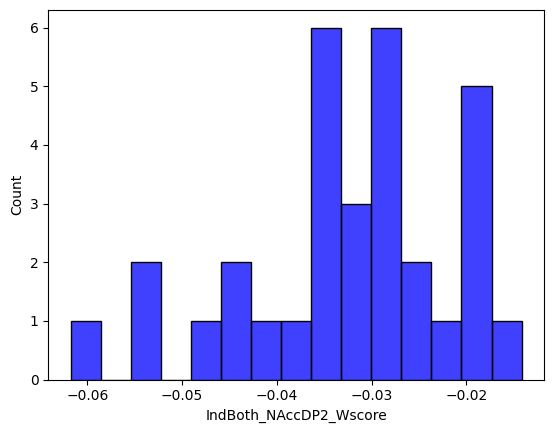

In [192]:
sns.histplot(boots_df["IndBoth_NAccDP2_Wscore"], color="blue", bins=15)
print("The mean of the individual correlation between NAcc_DP2 and W_score is: ", np.mean(boots_df["IndBoth_NAccDP2_Wscore"]))
print("The 95% CI of the individual correlation between NAcc_DP2 and W_score is: ", np.percentile(boots_df["IndBoth_NAccDP2_Wscore"], [2.5, 97.5]))




The mean of the individual correlation between NAcc_IP and W_score is:  0.07134702723328468
The 95% CI of the individual correlation between NAcc_IP and W_score is:  [0.06175887 0.08113886]


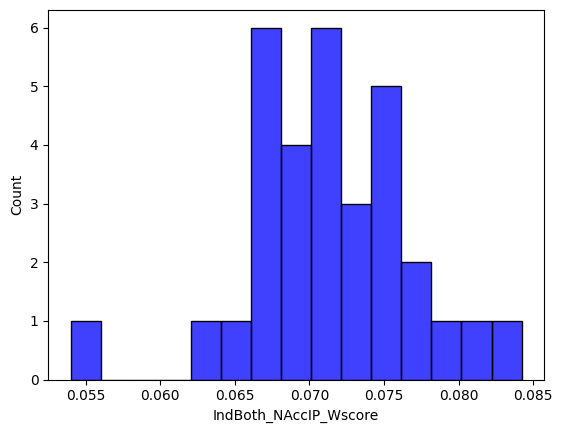

In [196]:
sns.histplot(boots_df["IndBoth_NAccIP_Wscore"], color="blue", bins=15)
print("The mean of the individual correlation between NAcc_IP and W_score is: ", np.mean(boots_df["IndBoth_NAccIP_Wscore"]))
print("The 95% CI of the individual correlation between NAcc_IP and W_score is: ", np.percentile(boots_df["IndBoth_NAccIP_Wscore"], [2.5, 97.5]))


The mean of the individual correlation between NAcc_IP and W_score for comedy is:  nan
The 95% CI of the individual correlation between NAcc_IP and W_score for comedy is:  [nan nan]


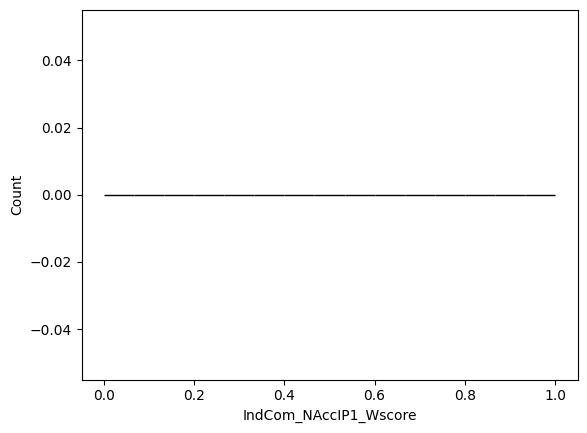

In [199]:
sns.histplot(boots_df["IndCom_NAccIP1_Wscore"], color="blue", bins=15)
print("The mean of the individual correlation between NAcc_IP and W_score for comedy is: ", np.mean(boots_df["IndCom_NAccIP_Wscore"]))
print("The 95% CI of the individual correlation between NAcc_IP and W_score for comedy is: ", np.percentile(boots_df["IndCom_NAccIP_Wscore"], [2.5, 97.5]))

The mean of the individual correlation between NAcc_Seg1 and W_score is:  0.03473651287933868
The 95% CI of the individual correlation between NAcc_Seg1 and W_score is:  [0.0254618  0.04721057]


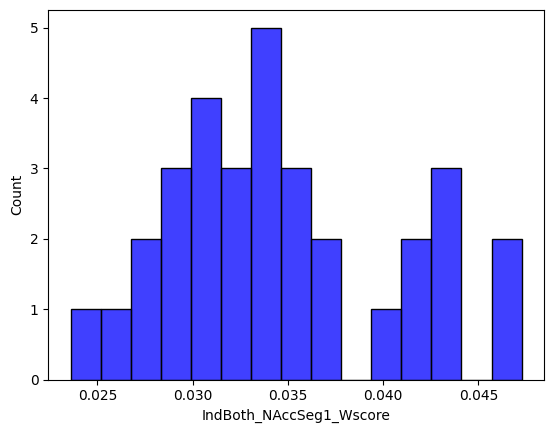

In [197]:
sns.histplot(boots_df["IndBoth_NAccSeg1_Wscore"], color="blue", bins=15)
print("The mean of the individual correlation between NAcc_Seg1 and W_score is: ", np.mean(boots_df["IndBoth_NAccSeg1_Wscore"]))
print("The 95% CI of the individual correlation between NAcc_Seg1 and W_score is: ", np.percentile(boots_df["IndBoth_NAccSeg1_Wscore"], [2.5, 97.5]))



The mean of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log is:  0.04362013222716771
The 95% CI of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log is:  [-0.01262475  0.08405056]


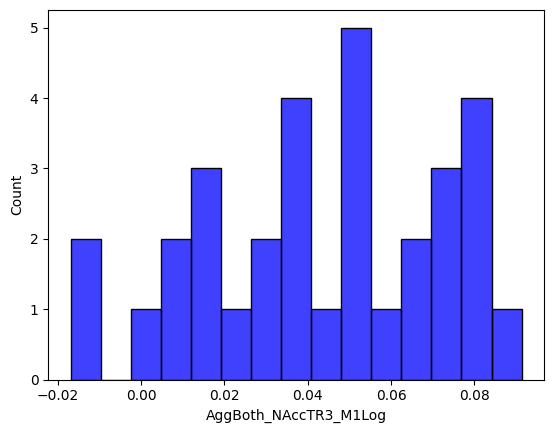

In [201]:
sns.histplot(boots_df["AggBoth_NAccTR3_M1Log"], color="blue", bins=15)
print("The mean of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log is: ", np.mean(boots_df["AggBoth_NAccTR3_M1Log"]))
print("The 95% CI of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log is: ", np.percentile(boots_df["AggBoth_NAccTR3_M1Log"], [2.5, 97.5]))


The mean of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log for comedy is:  0.31513377516524643
The 95% CI of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log for comedy is:  [0.25841838 0.40660253]


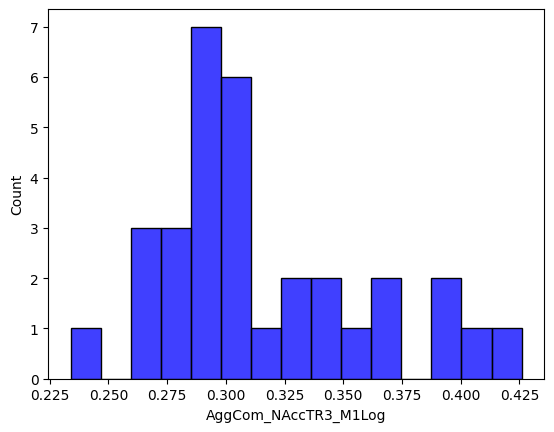

In [202]:
sns.histplot(boots_df["AggCom_NAccTR3_M1Log"], color="blue", bins=15)
print("The mean of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log for comedy is: ", np.mean(boots_df["AggCom_NAccTR3_M1Log"]))
print("The 95% CI of the aggregate correlation between NAcc_TR3 and Gross_M1_updated_log for comedy is: ", np.percentile(boots_df["AggCom_NAccTR3_M1Log"], [2.5, 97.5]))


The mean of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log is:  0.1104092588036629
The 95% CI of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log is:  [0.06446927 0.15656256]


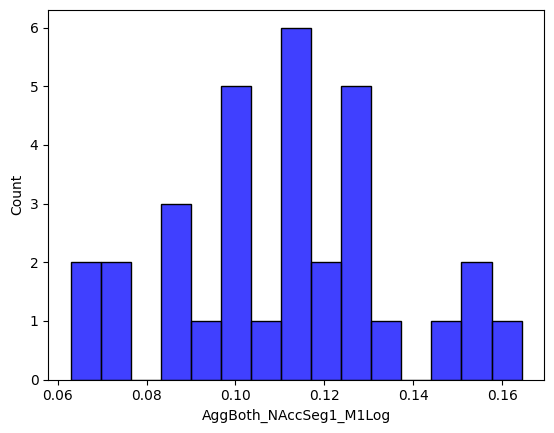

In [203]:
sns.histplot(boots_df["AggBoth_NAccSeg1_M1Log"], color="blue", bins=15)
print("The mean of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log is: ", np.mean(boots_df["AggBoth_NAccSeg1_M1Log"]))
print("The 95% CI of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log is: ", np.percentile(boots_df["AggBoth_NAccSeg1_M1Log"], [2.5, 97.5]))


The mean of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log for comedy is:  0.4196734433708701
The 95% CI of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log for comedy is:  [0.34150074 0.4942961 ]


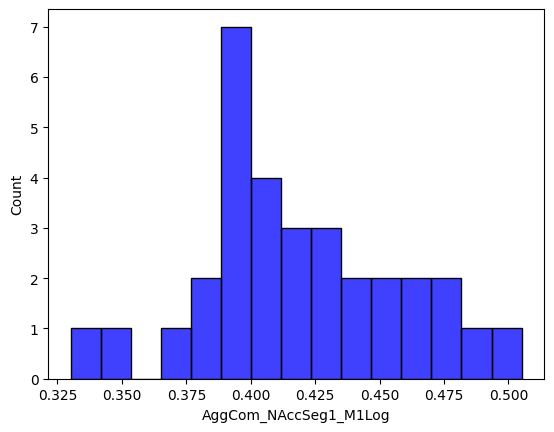

In [204]:
sns.histplot(boots_df["AggCom_NAccSeg1_M1Log"], color="blue", bins=15)
print("The mean of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log for comedy is: ", np.mean(boots_df["AggCom_NAccSeg1_M1Log"]))
print("The 95% CI of the aggregate correlation between NAcc_Seg1 and Gross_M1_updated_log for comedy is: ", np.percentile(boots_df["AggCom_NAccSeg1_M1Log"], [2.5, 97.5]))


The mean of the aggregate correlation between NAcc_DP2 and Gross_M1_updated_log is:  0.28123505422960937
The 95% CI of the aggregate correlation between NAcc_DP2 and Gross_M1_updated_log is:  [0.15285126 0.39790227]


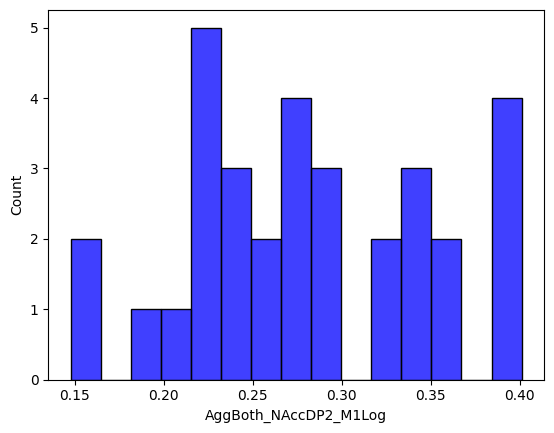

In [200]:
sns.histplot(boots_df["AggBoth_NAccDP2_M1Log"], color="blue", bins=15)
print("The mean of the aggregate correlation between NAcc_DP2 and Gross_M1_updated_log is: ", np.mean(boots_df["AggBoth_NAccDP2_M1Log"]))
print("The 95% CI of the aggregate correlation between NAcc_DP2 and Gross_M1_updated_log is: ", np.percentile(boots_df["AggBoth_NAccDP2_M1Log"], [2.5, 97.5]))



The mean of the AggCom_NAccDP2_M1Log is:  0.5675045570420134
The median of the AggCom_NAccDP2_M1Log is:  0.6238098897514062
The 95% CI of the AggCom_NAccDP2_M1Log is:  [0.3128676  0.70188031]


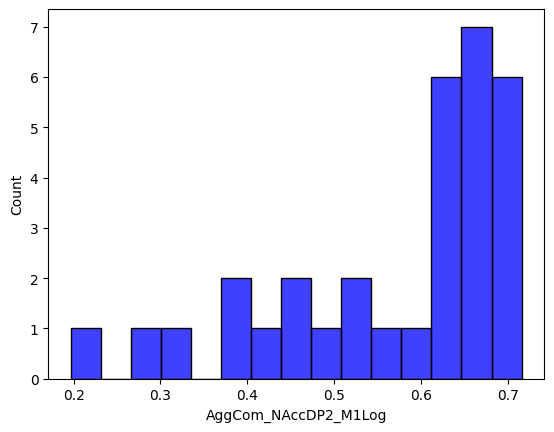

In [191]:
sns.histplot(boots_df["AggCom_NAccDP2_M1Log"], color="blue", bins=15)
print("The mean of the AggCom_NAccDP2_M1Log is: ", np.mean(boots_df["AggCom_NAccDP2_M1Log"]))
print("The median of the AggCom_NAccDP2_M1Log is: ", np.median(boots_df["AggCom_NAccDP2_M1Log"]))
print("The 95% CI of the AggCom_NAccDP2_M1Log is: ", np.percentile(boots_df["AggCom_NAccDP2_M1Log"], [5, 95]))
 